In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict

from utils import *
from dl_utils import *
from drug_utils import *

test_type = "rna"
norm1W = False
zscore = False
raw_dir = "../data/cleaned_unpaired/"
aligned_dir = "../data/cleaned_unpaired/deepAligner_DML/sortedrna_ln_pre_MNNRaw_150K"
out_dir = "../data/cleaned_unpaired/dose_featImp";os.makedirs(out_dir, exist_ok = True)
dose_path = os.path.join(raw_dir, "GDSC2_fitted_dose_response_24Jul22.csv")
bio_path = os.path.join(raw_dir, "cl_ids.csv")
split_path = os.path.join(raw_dir, "data_split_622.csv")
## load bio information
bio_df = pd.read_csv(bio_path)
bio_df["ID"] = bio_df["ID"].astype("int")
bio_df.rename(columns = {"COSMICID": "COSMIC_ID"}, inplace = True)
## load ids for DeepAlginer cancer test
split_df = pd.read_csv(split_path)
split_ids = split_df["ID"].values.squeeze()
## load drug response information
dose_df = pd.read_csv(dose_path)

In [2]:
def filter_out_downstream_data(data_rna, data_arr, split_ids, norm1W):
    # ## pop ids
    ids_rna, ids_arr = data_rna.pop("ID").values.squeeze(), data_arr.pop("ID").values.squeeze()
    rna_mask = np.array([True if id_ in split_ids else False for id_ in ids_rna])
    arr_mask = np.array([True if id_ in split_ids else False for id_ in ids_arr])
    data_rna, data_arr = data_rna[rna_mask], data_arr[arr_mask]
    ids_rna, ids_arr = ids_rna[rna_mask].tolist(), ids_arr[arr_mask].tolist()
    if norm1W:
        # ## sample normalization
        data_sum = np.expand_dims(data_rna.sum(axis = 1).values, axis = 1)
        data_rna = data_rna / data_sum * 10000
        data_sum = np.expand_dims(data_arr.sum(axis = 1).values, axis = 1)
        data_arr = data_arr / data_sum * 10000
    return data_rna.values.squeeze(), data_arr.values.squeeze(), ids_rna, ids_arr
    
# ## load raw data
rna_path = os.path.join(raw_dir, "cl_rna.csv")
arr_path = os.path.join(raw_dir, "cl_arr.csv")
raw_rna = pd.read_csv(rna_path)
raw_arr = pd.read_csv(arr_path)
ref_genes = list(raw_rna.columns)
raw_rna, raw_arr, raw_rna_ids, raw_arr_ids = filter_out_downstream_data(raw_rna, raw_arr, split_ids, norm1W)
## load aligned data
rna_path = os.path.join(aligned_dir, "cl_rna_aligned.csv")
arr_path = os.path.join(aligned_dir, "cl_arr_aligned.csv")
aligned_rna = pd.read_csv(rna_path)
aligned_arr = pd.read_csv(arr_path)
## rearrange the columns
aligned_rna, aligned_arr = aligned_rna[ref_genes], aligned_arr[ref_genes]
aligned_rna, aligned_arr, aligned_rna_ids, aligned_arr_ids = filter_out_downstream_data(aligned_rna, aligned_arr, split_ids, norm1W)
ref_genes.remove("ID")

## cal significance in whole data

In [ ]:
from joblib import load
sig_th = 0.05
drug_names = list(sorted(set(dose_df["DRUG_NAME"].values.squeeze().tolist())))
# drug_names = [
#     "5-Fluorouracil",
#     "Trametinib",
#     "SN-38"
# ]
model_sig = load(os.path.join(raw_dir, "cancer_sig.joblib"))

raw_rna_cosmic_ids = np.array([get_cosmic_id(bio_df, id_) for id_ in raw_rna_ids])
raw_arr_cosmic_ids = np.array([get_cosmic_id(bio_df, id_) for id_ in raw_arr_ids])
aligned_rna_cosmic_ids = np.array([get_cosmic_id(bio_df, id_) for id_ in aligned_rna_ids])
aligned_arr_cosmic_ids = np.array([get_cosmic_id(bio_df, id_) for id_ in aligned_arr_ids])

feat_num = raw_rna.shape[1]
potential_drugs = []
drug_ss, drug_nn, drug_sn, drug_ns = {}, {}, {}, {}
for drug in drug_names:
    this_raw_rna, this_raw_arr = raw_rna.copy(), raw_arr.copy()
    this_aligned_rna, this_aligned_arr = aligned_rna.copy(), aligned_arr.copy()
    
    dose_mask = dose_df["DRUG_NAME"] == drug
    this_dose = dose_df[dose_mask]
    
    raw_rna_lnic50s, raw_rna_mask = get_lnic50(this_dose, raw_rna_cosmic_ids)
    raw_arr_lnic50s, raw_arr_mask = get_lnic50(this_dose, raw_arr_cosmic_ids)
    aligned_rna_lnic50s, aligned_rna_mask = get_lnic50(this_dose, aligned_rna_cosmic_ids)
    aligned_arr_lnic50s, aligned_arr_mask = get_lnic50(this_dose, aligned_arr_cosmic_ids)
    
    this_raw_rna, this_raw_arr = this_raw_rna[raw_rna_mask], this_raw_arr[raw_arr_mask]
    this_aligned_rna, this_aligned_arr = this_aligned_rna[aligned_rna_mask], this_aligned_arr[aligned_arr_mask]
    if len(this_raw_rna) == 0:
        continue

    ## take 25 percentile as the sensitive label
    threshold = np.percentile(raw_rna_lnic50s, 25)
    raw_labels_rna = raw_rna_lnic50s <= threshold
    raw_labels_arr = raw_arr_lnic50s <= threshold
    raw_labels_rna = raw_labels_rna.astype("int")
    raw_labels_arr = raw_labels_arr.astype("int")
    aligned_labels_rna = aligned_rna_lnic50s <= threshold
    aligned_labels_arr = aligned_arr_lnic50s <= threshold
    aligned_labels_rna = aligned_labels_rna.astype("int")
    aligned_labels_arr = aligned_labels_arr.astype("int")    

    outs = []
    ss, nn, sn, ns = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)
    for feat_idx in tqdm(range(feat_num), ncols = 80):
        raw_rna_p = get_significance(this_raw_rna[:, feat_idx], raw_labels_rna)
        raw_arr_p = get_significance(this_raw_arr[:, feat_idx], raw_labels_arr)

        aligned_rna_p = get_significance(this_aligned_rna[:, feat_idx], aligned_labels_rna)
        aligned_arr_p = get_significance(this_aligned_arr[:, feat_idx], aligned_labels_arr)
        outs.append([feat_idx, ref_genes[feat_idx], raw_rna_p, raw_arr_p, aligned_rna_p, aligned_arr_p])
        
        if raw_rna_p < sig_th and raw_arr_p < sig_th:
            ss[0] += 1
        if aligned_rna_p < sig_th and aligned_arr_p < sig_th:
            ss[1] += 1
        if raw_rna_p >= sig_th and raw_arr_p >= sig_th:
            nn[0] += 1
        if aligned_rna_p >= sig_th and aligned_arr_p >= sig_th:
            nn[1] += 1
        if raw_rna_p >= sig_th and raw_arr_p < sig_th:
            ns[0] += 1
        if aligned_rna_p >= sig_th and aligned_arr_p < sig_th:
            ns[1] += 1            
        if raw_rna_p < sig_th and raw_arr_p >= sig_th:
            sn[0] += 1
        if aligned_rna_p < sig_th and aligned_arr_p >= sig_th:
            sn[1] += 1
    ss, nn, ns, sn = ss/feat_num*100, nn/feat_num*100, ns/feat_num*100, sn/feat_num*100
    xs, ys, hues = [], [], []
    ys.extend(ss); xs.extend(["S&S", "S&S"]); hues.extend(["Raw", "Aligned"])
    ys.extend(nn); xs.extend(["N&N", "N&N"]); hues.extend(["Raw", "Aligned"])
    ys.extend(ns); xs.extend(["N&S", "N&S"]); hues.extend(["Raw", "Aligned"])
    ys.extend(sn); xs.extend(["S&N", "S&N"]); hues.extend(["Raw", "Aligned"])
#     plot_df = pd.DataFrame()
#     plot_df["Significance"] = xs
#     plot_df["Number of genes (%)"] = ys
#     plot_df["Aligned or not"] = hues
#     fig = plt.figure(dpi = 600, figsize = (4, 3))
#     plt.title(drug)
#     sns.barplot(plot_df, x = "Significance", y = "Number of genes (%)", hue = "Aligned or not", orient = "v")
#     plt.savefig(os.path.join(out_dir, "{}.png".format(drug.replace("/", "_"))), bbox_inches = "tight")
    
    drug_ss[drug], drug_nn[drug], drug_sn[drug], drug_ns[drug] = ss, nn, sn, ns
    sig_data = np.array([ss[0], nn[0], sn[0], ns[0], ss[1], nn[1], sn[1], ns[1]])
    impr_pred = model_sig.predict(sig_data.reshape(1, -1))[0]
    print(impr_pred, drug)
    if impr_pred == 1:
        potential_drugs.append(drug)
        print(sig_data)
            
#     df = pd.DataFrame(outs, columns = ["Idx", "Gene", "Raw_RNA_P", "Raw_Arr_P", "Aligned_RNA_P", "Aligned_Arr_P"])
#     df.to_excel(os.path.join(out_dir, "{}.xlsx".format(drug.replace("/", "_"))), index = False)
print(potential_drugs)

100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1075.54it/s]


0 123138


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1074.68it/s]


1 123829
[ 5.8989453  83.19843022  6.18714741  4.67868531  2.27495708 89.01152808
  5.21216581  3.50134903]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1072.92it/s]


1 150412
[26.61270542 46.78685308 12.12288447 14.44076527 37.77900417 45.32744665
  7.91636007  8.97718911]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1053.62it/s]


0 5-Fluorouracil


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1072.26it/s]


0 5-azacytidine


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1066.23it/s]


0 50869


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1060.07it/s]


0 615590


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1062.16it/s]


0 630600


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1063.37it/s]


0 667880


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1064.85it/s]


0 720427


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1064.00it/s]


0 729189


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1068.01it/s]


1 741909
[ 7.98994359 79.421143    6.34044641  6.21167525  4.78906058 87.81579593
  6.13809173  1.25705175]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1067.63it/s]


1 743380
[11.73657101 73.70615649  6.90458671  7.61589404 17.82560706 67.83173902
  5.3961246   8.94652931]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1072.26it/s]


0 765771


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1066.70it/s]


0 776928


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1063.53it/s]


0 A-366


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1053.83it/s]


0 ABT737


100%|███████████████████████████████████| 16308/16308 [00:16<00:00, 1012.31it/s]


0 AGI-5198


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1028.06it/s]


0 AGI-6780


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1035.92it/s]


0 AGK2


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1036.05it/s]


0 AMG-319


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1038.32it/s]


0 AT13148


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1034.98it/s]


0 AZ6102


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1038.04it/s]


0 AZ960


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1043.71it/s]


0 AZD1208


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1049.52it/s]


0 AZD1332


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1044.10it/s]


1 AZD2014
[ 7.79985283 76.82119205  6.63478048  8.70738288 45.61564876 34.20407162
 11.83468236  8.34559725]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1035.57it/s]


0 AZD3759


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1042.41it/s]


0 AZD4547


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1050.06it/s]


0 AZD5153


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1045.39it/s]


0 AZD5363


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1062.94it/s]


0 AZD5438


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1065.05it/s]


0 AZD5582


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1063.87it/s]


0 AZD5991


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1106.94it/s]


1 AZD6482
[ 8.60927152 72.54108413  8.0941869  10.53470689 14.09124356 68.5675742
  9.64557273  7.69560952]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1064.05it/s]


0 AZD6738


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1060.26it/s]


0 AZD7762


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1064.53it/s]


1 AZD8055
[13.26342899 66.09026245 10.57149865 10.02575423 44.76943831 32.99607555
  8.83002208 13.40446407]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1060.07it/s]


1 AZD8186
[12.17807211 71.83590876  7.96541575  7.98994359 27.40372823 53.11503557
  4.70934511 14.7718911 ]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1052.19it/s]


0 Afatinib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1056.37it/s]


0 Afuresertib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1046.97it/s]


0 Alisertib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1020.17it/s]


1 Alpelisib
[20.56659308 51.77213637 12.85871965 14.7718911  33.63993132 50.54574442
  6.16261957  9.65170468]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1035.10it/s]


0 Avagacestat


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1033.08it/s]


0 Axitinib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1047.48it/s]


0 BDF00022089a


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1043.06it/s]


0 BDILV000379a


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1039.48it/s]


0 BDOCA000347a


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1039.47it/s]


0 BDP-00009066


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1048.78it/s]


0 BEN


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1031.77it/s]


0 BI-2536


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1027.53it/s]


0 BIBR-1532


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1037.52it/s]


0 BMS-345541


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1037.99it/s]


1 BMS-536924
[14.47142507 60.54697081 15.71008094  9.24086338 17.38410596 59.09982831
 16.37846456  7.13760118]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1036.59it/s]


0 BMS-754807


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1052.13it/s]


0 BPD-00008900


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1109.64it/s]


1 BX795
[10.9148884  68.20578857  8.48050037 12.05543292 35.25263674 51.50233014
  6.02771646  7.21731665]


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1115.22it/s]


1 Bicalutamide
[15.96762325 56.07064018 11.34412558 16.27422124 34.8785872  49.95094432
  7.72013736  7.45033113]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1057.04it/s]


1 Bleomycin
[13.99926416 68.37135148  8.8116262   8.7809664  44.6038754  29.54991415
 12.88937945 12.956831  ]


100%|████████████████████████████████████| 16308/16308 [00:27<00:00, 582.95it/s]


1 Bleomycin (50 uM)
[12.14128035 69.5425558   9.02011283  9.24699534 36.74883493 41.74025018
  9.16727986 12.34363503]


100%|████████████████████████████████████| 16308/16308 [00:23<00:00, 690.65it/s]


0 Bortezomib


100%|████████████████████████████████████| 16308/16308 [00:22<00:00, 725.03it/s]


0 Bosutinib


100%|████████████████████████████████████| 16308/16308 [00:30<00:00, 526.22it/s]


0 Bromosporine


100%|████████████████████████████████████| 16308/16308 [00:27<00:00, 586.05it/s]


0 Buparlisib


100%|████████████████████████████████████| 16308/16308 [00:26<00:00, 612.50it/s]


1 CCT-018159
[ 3.36644592 81.88005887  6.48148148  7.92862399  7.63428992 82.88570027
  5.04660289  4.43340692]


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 652.44it/s]


0 CCT007093


100%|████████████████████████████████████| 16308/16308 [00:27<00:00, 600.82it/s]


0 CDK9_5038


100%|████████████████████████████████████| 16308/16308 [00:26<00:00, 615.39it/s]


0 CDK9_5576


100%|████████████████████████████████████| 16308/16308 [00:27<00:00, 595.29it/s]


0 CHIR-99021


100%|████████████████████████████████████| 16308/16308 [00:30<00:00, 539.92it/s]


0 CPI-637


100%|████████████████████████████████████| 16308/16308 [00:28<00:00, 576.41it/s]


0 CT7033-2


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 668.90it/s]


0 CZC24832


100%|████████████████████████████████████| 16308/16308 [00:27<00:00, 583.31it/s]


0 Camptothecin


100%|████████████████████████████████████| 16308/16308 [00:19<00:00, 819.01it/s]


0 Cediranib


100%|████████████████████████████████████| 16308/16308 [00:28<00:00, 579.69it/s]


0 Cisplatin


100%|████████████████████████████████████| 16308/16308 [00:23<00:00, 708.76it/s]


0 Crizotinib


100%|████████████████████████████████████| 16308/16308 [00:25<00:00, 639.84it/s]


0 Cyclophosphamide


100%|████████████████████████████████████| 16308/16308 [00:20<00:00, 777.14it/s]


0 Cytarabine


100%|████████████████████████████████████| 16308/16308 [00:25<00:00, 644.40it/s]


0 Dabrafenib


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 652.54it/s]


0 Dacarbazine


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 658.20it/s]


1 Dactinomycin
[14.19548688 50.61319598 18.92935982 15.93083149 32.92862399 48.17267599
 10.47338729  8.42531273]


100%|████████████████████████████████████| 16308/16308 [00:16<00:00, 964.14it/s]


0 Dactolisib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1085.99it/s]


0 Daporinad


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1061.71it/s]


0 Dasatinib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1072.01it/s]


1 Dihydrorotenone
[11.27667403 73.01324503  7.93475595  7.73853324 25.80328673 53.31125828
  9.73142016 11.15403483]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1062.12it/s]


0 Dinaciclib


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1090.59it/s]


1 Docetaxel
[12.47853814 53.01692421 19.21142997 15.01103753 28.10890361 53.31125828
 12.40495462  6.17488349]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1061.58it/s]


0 Doramapimod


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1061.28it/s]


0 EHT-1864


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1060.75it/s]


0 EPZ004777


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1055.64it/s]


0 EPZ5676


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1069.49it/s]


1 ERK_2440
[12.61957322 70.92837871  8.92813343  7.48712288 33.35786117 45.81187147
  5.21829777 15.61196959]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1068.52it/s]


1 ERK_6604
[15.6548933  61.37478538 12.64410105 10.2894285  14.44689723 66.82609762
 10.89649252  7.83051263]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1070.66it/s]


0 Eg5_9814


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1069.34it/s]


0 Elephantin


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1101.76it/s]


1 Elesclomol
[ 9.68849644 65.62423351 12.79126809 11.55261221 16.16997792 67.3166544
 13.03041452  3.48295315]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1055.46it/s]


0 Entinostat


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1050.11it/s]


0 Entospletinib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1056.02it/s]


0 Epirubicin


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1055.97it/s]


0 Erlotinib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1069.39it/s]


0 Fludarabine


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1066.39it/s]


0 Foretinib


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1113.86it/s]


0 Fulvestrant


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1063.26it/s]


0 GDC0810


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1056.15it/s]


1 GNE-317
[11.66298749 71.06941378  7.92862399  9.30831494 28.91219034 56.59185676
  6.74515575  7.75079715]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1073.02it/s]


0 GSK-LSD1


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1068.67it/s]


0 GSK-LSD1-2HCl 


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1055.26it/s]


0 GSK1904529A


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1067.29it/s]


1 GSK2110183B
[25.04292372 50.88300221 10.30169242 13.73558989 38.5822909  45.96517047
  5.19376993 10.2587687 ]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1070.86it/s]


0 GSK2256098C


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1067.80it/s]


0 GSK2276186C


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1063.64it/s]


0 GSK2578215A


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1058.84it/s]


0 GSK2606414


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1113.03it/s]


0 GSK269962A


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1073.65it/s]


0 GSK2801


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1070.51it/s]


0 GSK2830371


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1063.12it/s]


0 GSK2830371A


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1064.80it/s]


0 GSK3337463A


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1108.08it/s]


1 GSK343
[16.55015943 50.46602894 17.20014717 15.52612215 37.25778759 45.26612705
 11.57714005  5.8989453 ]


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1062.10it/s]


0 GSK591


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1071.45it/s]


0 GSK626616AC


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1055.82it/s]


0 GW441756


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1070.06it/s]


0 Gallibiscoquinazole


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1059.31it/s]


0 Gefitinib


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1060.92it/s]


0 Gemcitabine


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1065.05it/s]


0 HKMTI-1-005


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1069.32it/s]


0 I-BET-762


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1053.37it/s]


0 I-BRD9


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1071.77it/s]


0 IAP_5620


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1070.26it/s]


0 ICL-SIRT078


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1071.00it/s]


0 IGF1R_3801


100%|███████████████████████████████████| 16308/16308 [00:14<00:00, 1108.06it/s]


0 IOX2


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1069.71it/s]


0 IRAK4_4710


100%|███████████████████████████████████| 16308/16308 [00:15<00:00, 1048.43it/s]


0 IWP-2


100%|████████████████████████████████████| 16308/16308 [00:25<00:00, 630.41it/s]


0 Ibrutinib


100%|████████████████████████████████████| 16308/16308 [00:26<00:00, 618.88it/s]


1 Ipatasertib
[24.62595045 49.48491538 10.67574197 15.1827324  36.4790287  44.47510424
  6.09516802 12.95069904]


100%|████████████████████████████████████| 16308/16308 [00:25<00:00, 647.42it/s]


0 Irinotecan


100%|████████████████████████████████████| 16308/16308 [00:26<00:00, 611.04it/s]


0 JAK1_8709


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 662.68it/s]


0 JAK_8517


100%|████████████████████████████████████| 16308/16308 [00:21<00:00, 747.04it/s]


0 JNK Inhibitor VIII


100%|████████████████████████████████████| 16308/16308 [00:26<00:00, 618.45it/s]


0 JQ1


100%|████████████████████████████████████| 16308/16308 [00:26<00:00, 618.38it/s]


0 KRAS (G12C) Inhibitor-12


100%|████████████████████████████████████| 16308/16308 [00:25<00:00, 628.62it/s]


0 KU-55933


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 661.80it/s]


0 L-Oxonoreleagnine


100%|████████████████████████████████████| 16308/16308 [00:22<00:00, 716.78it/s]


1 LCL161
[16.94260486 58.57861172 12.29457935 12.15354427 34.96443463 48.52832965
  9.51680157  6.99043414]


100%|████████████████████████████████████| 16308/16308 [00:27<00:00, 592.40it/s]


0 LGK974


100%|████████████████████████████████████| 16308/16308 [00:25<00:00, 643.39it/s]


0 LJI308


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 668.82it/s]


0 LMB_AB1


100%|████████████████████████████████████| 16308/16308 [00:23<00:00, 683.55it/s]


0 LMB_AB2


100%|████████████████████████████████████| 16308/16308 [00:24<00:00, 676.94it/s]


0 LMB_AB3


100%|████████████████████████████████████| 16308/16308 [00:21<00:00, 752.03it/s]


0 LMP744


 52%|███████████████████▍                 | 8543/16308 [00:10<00:14, 526.20it/s]

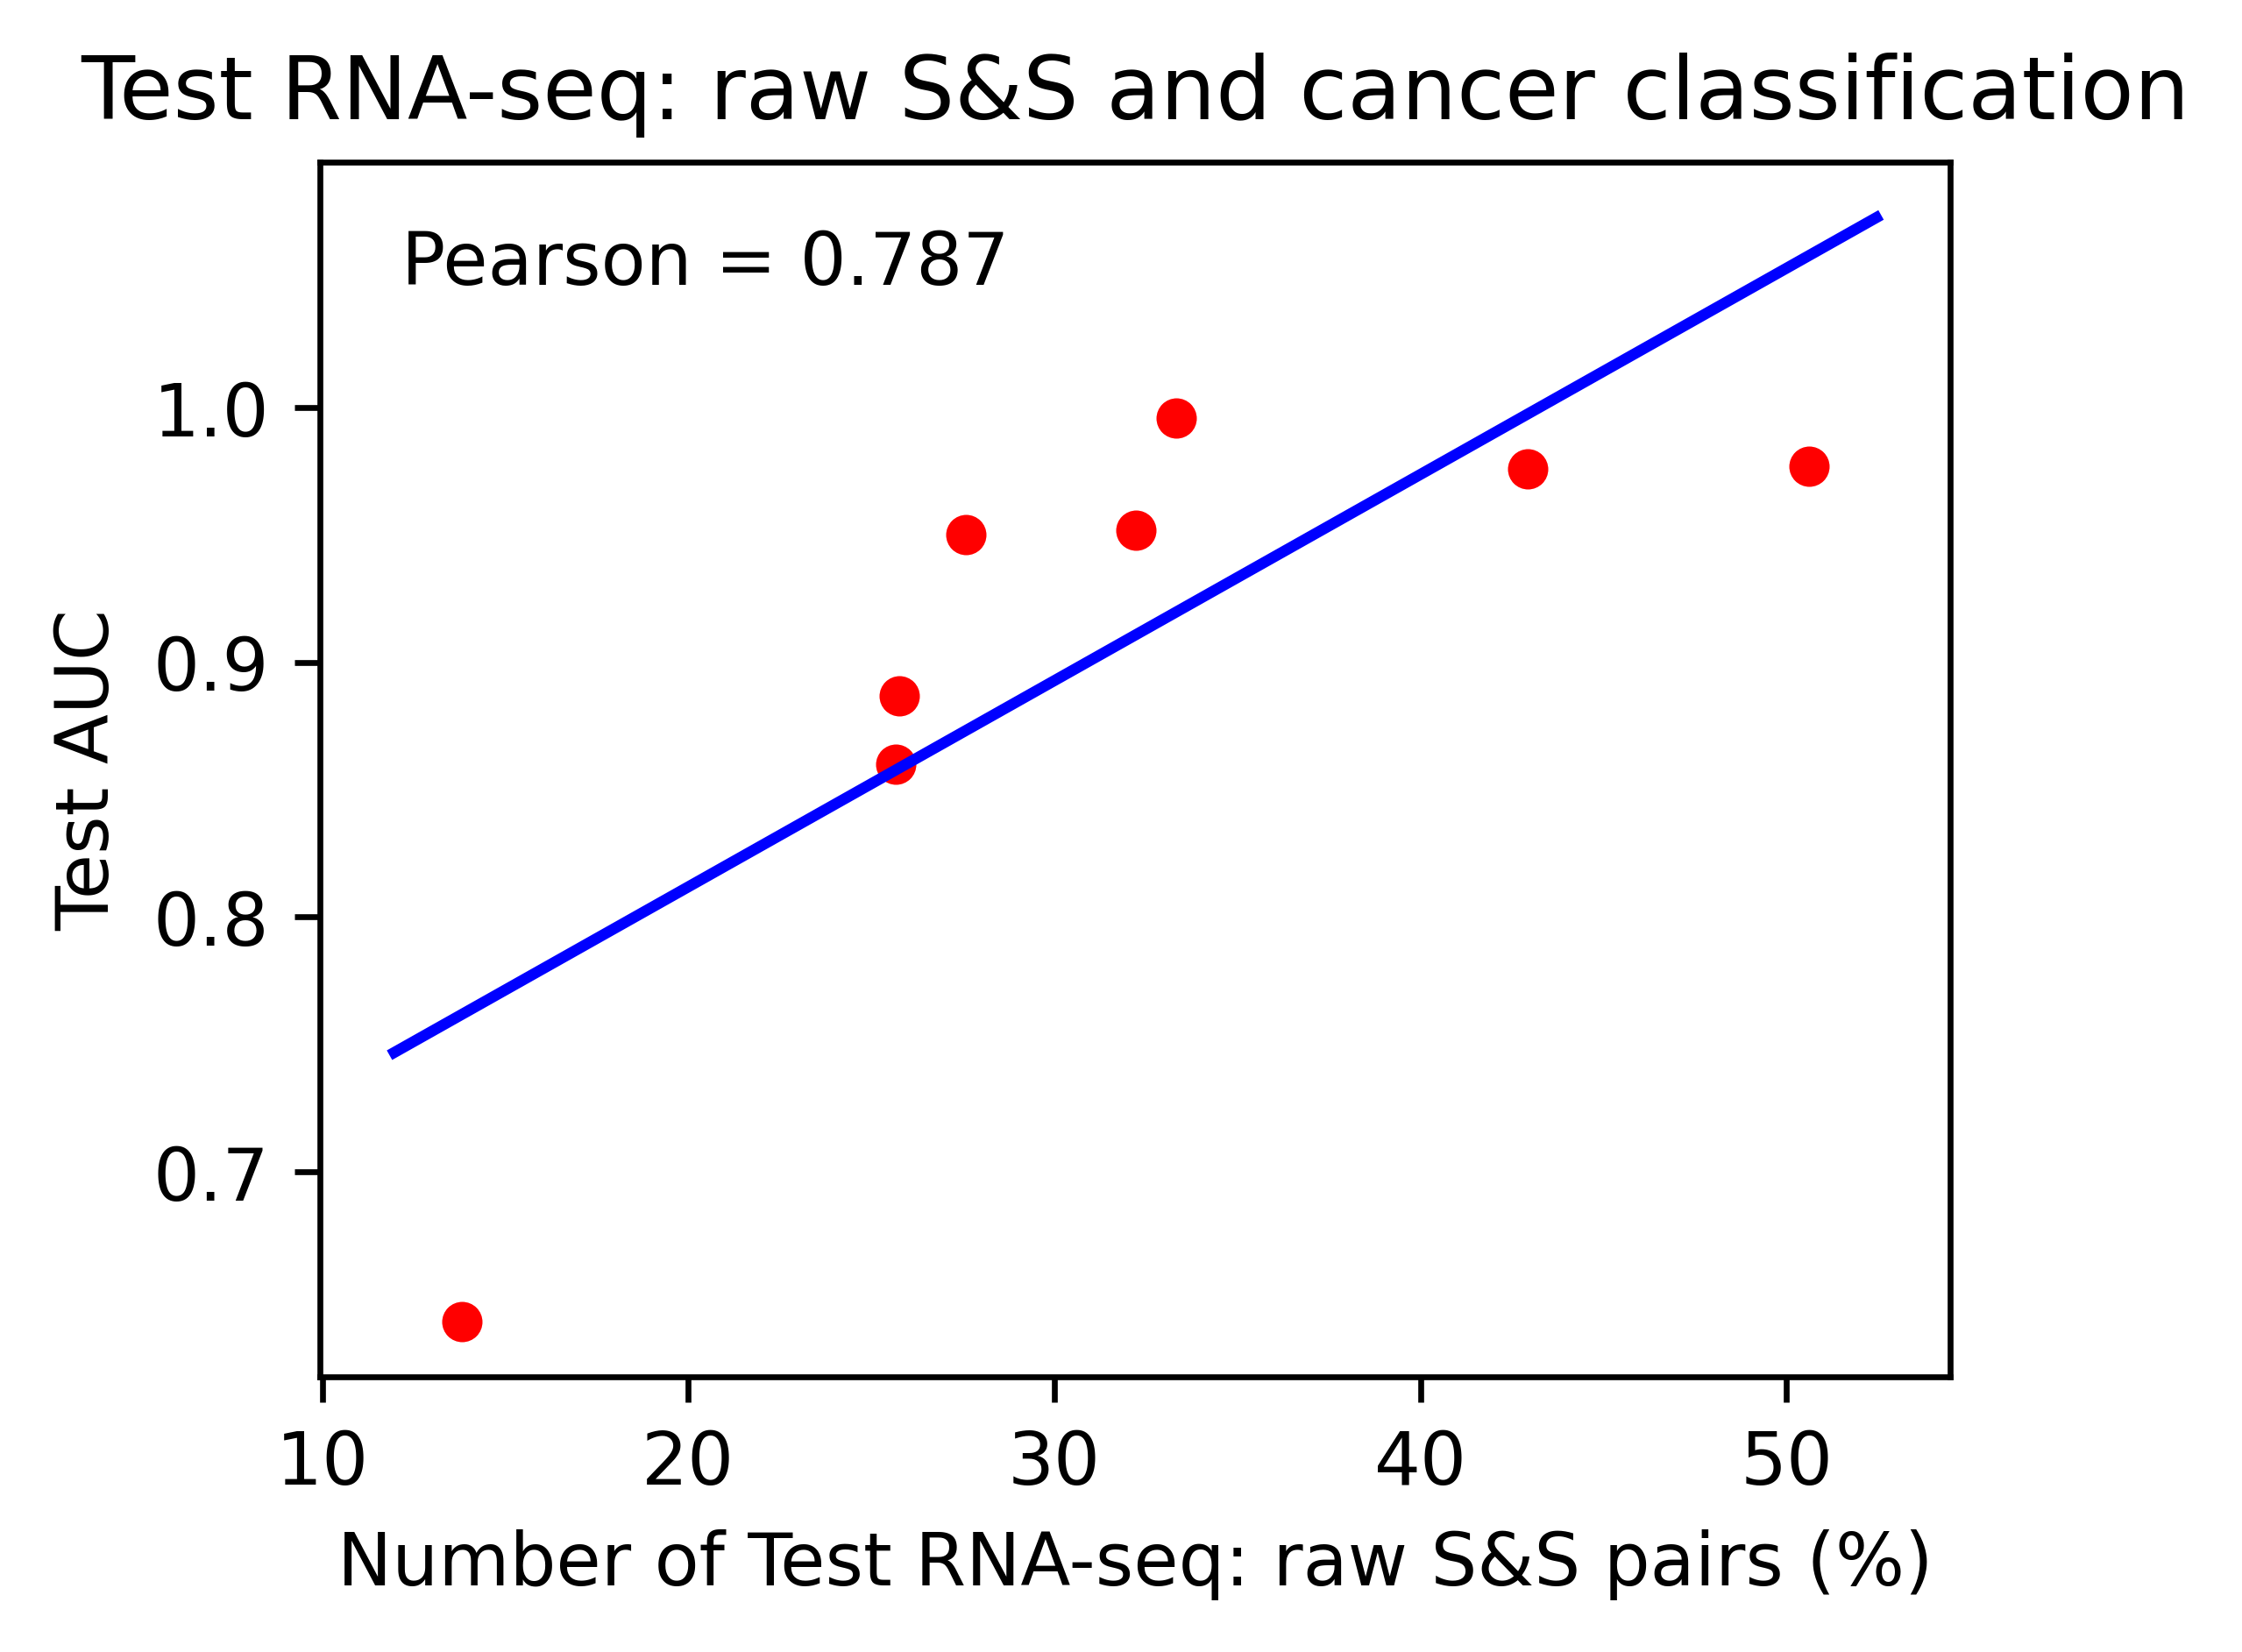

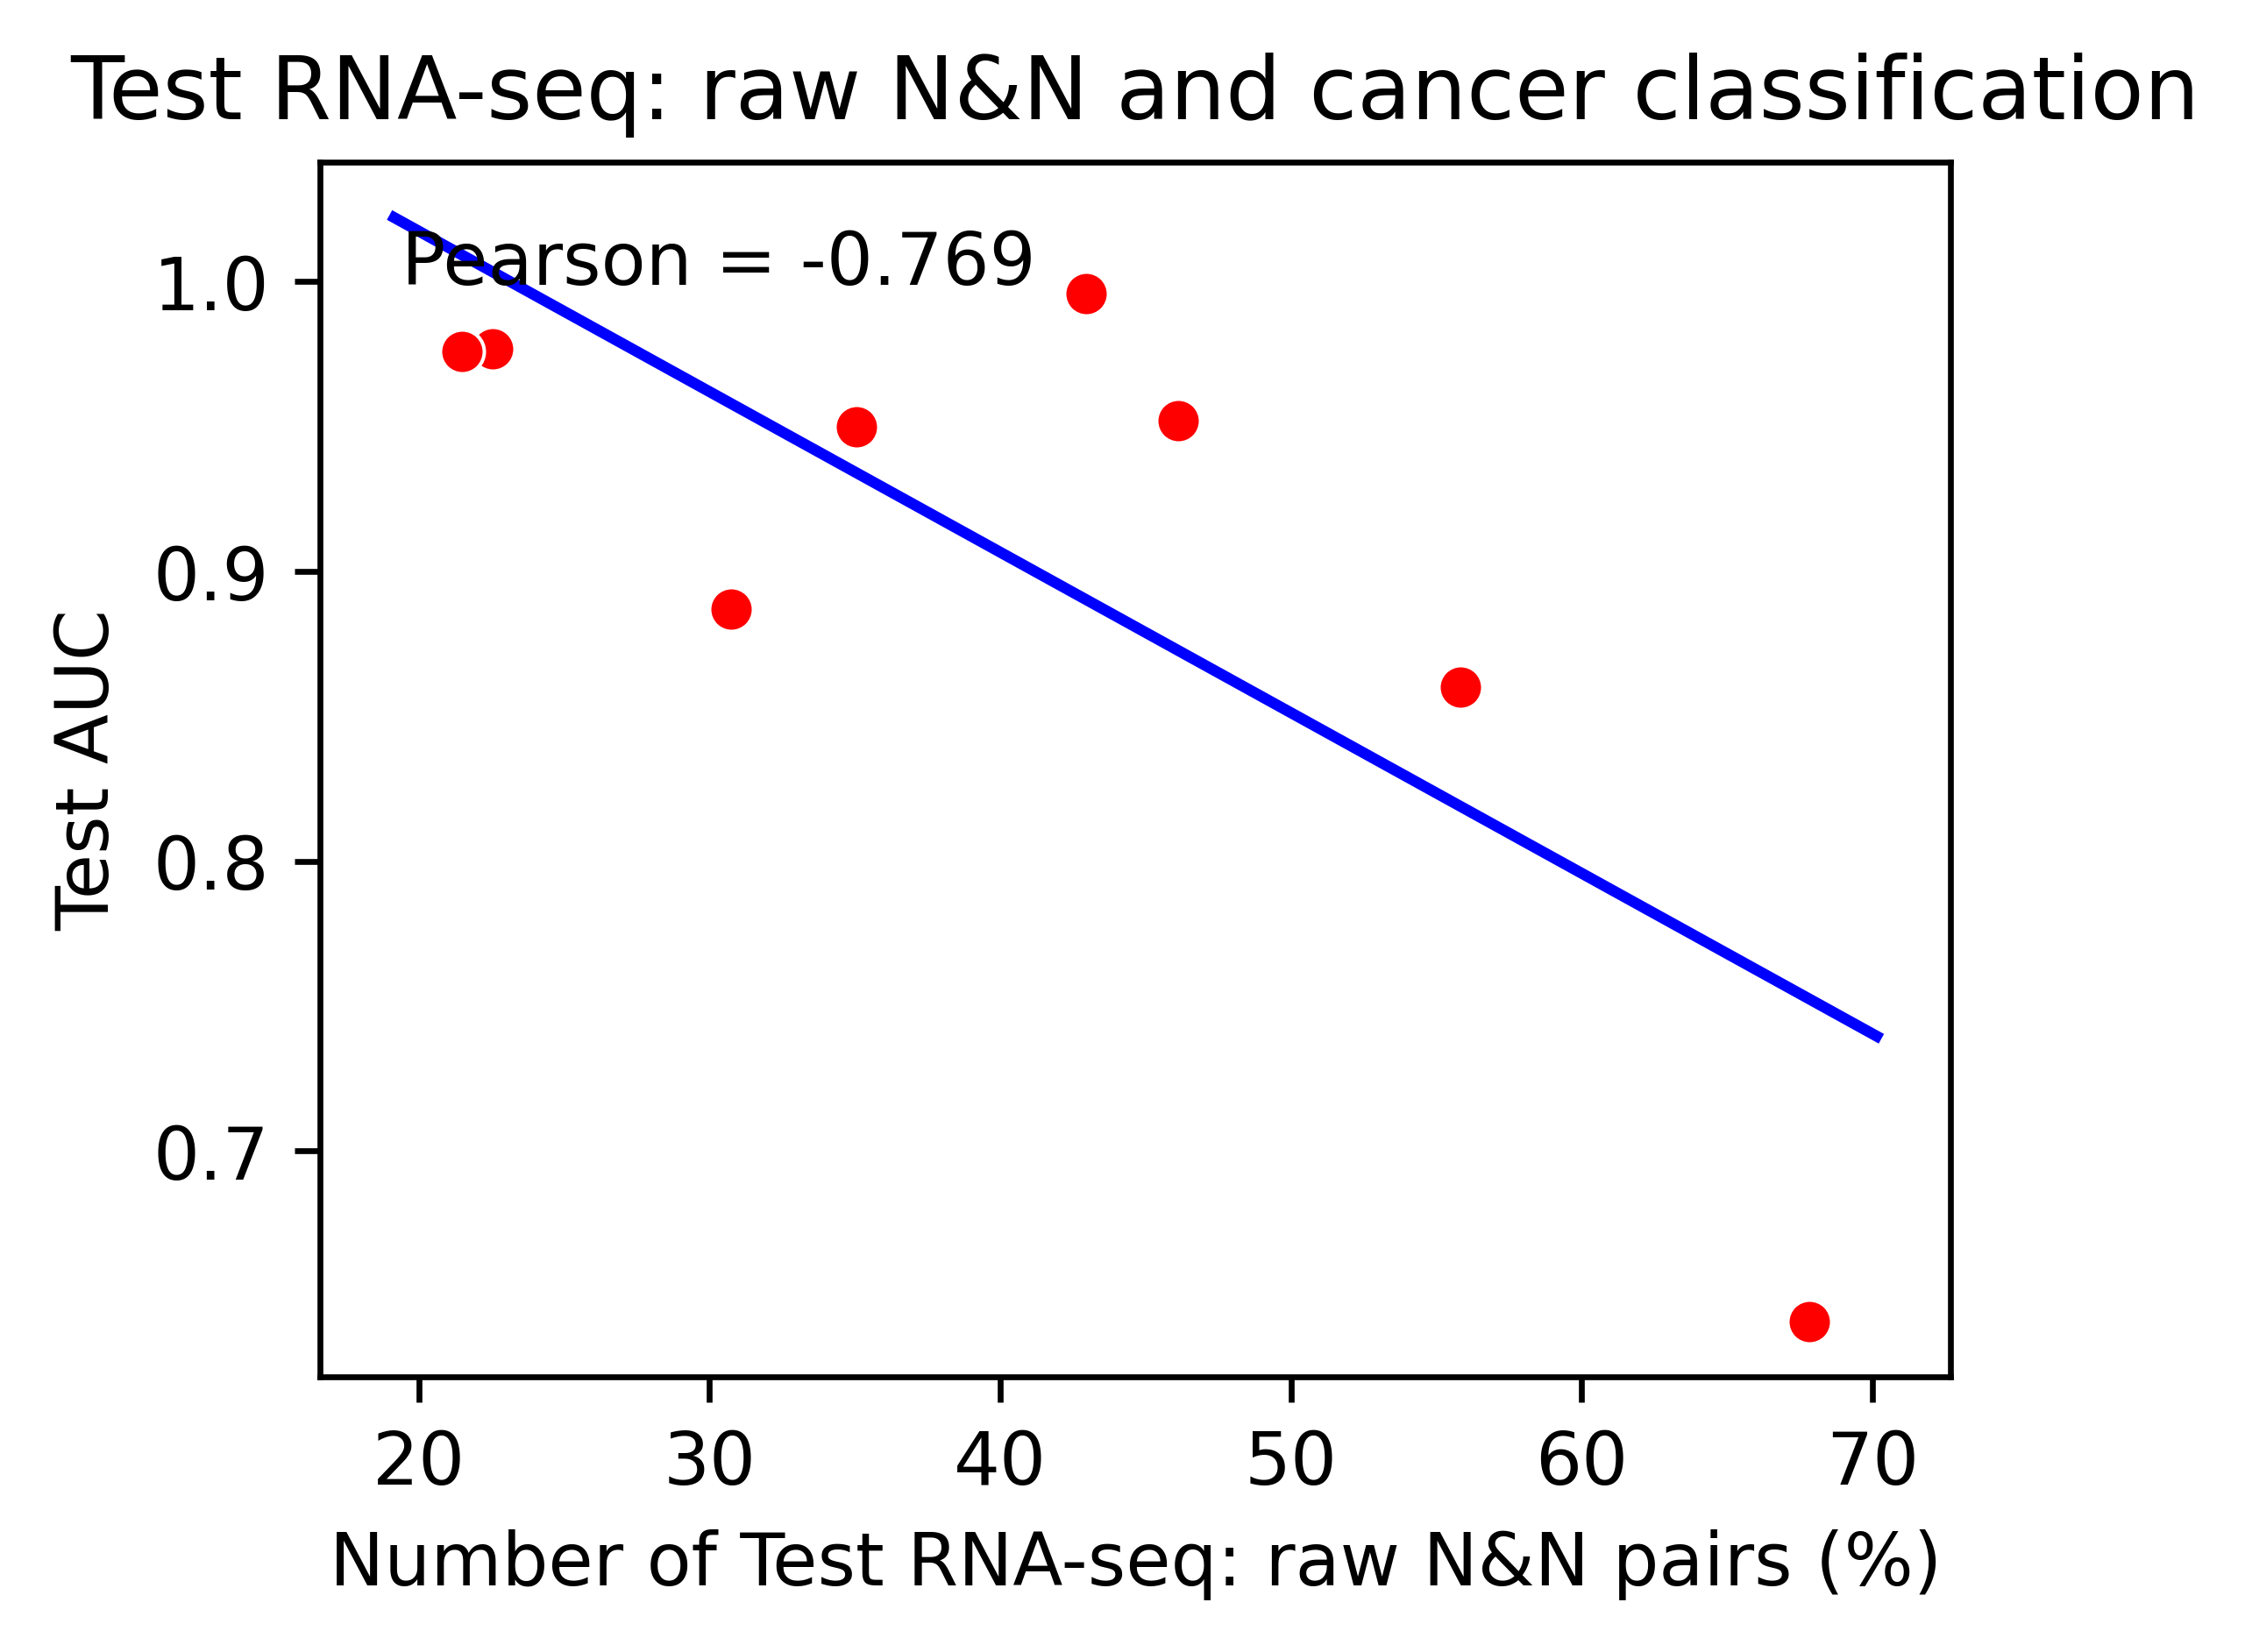

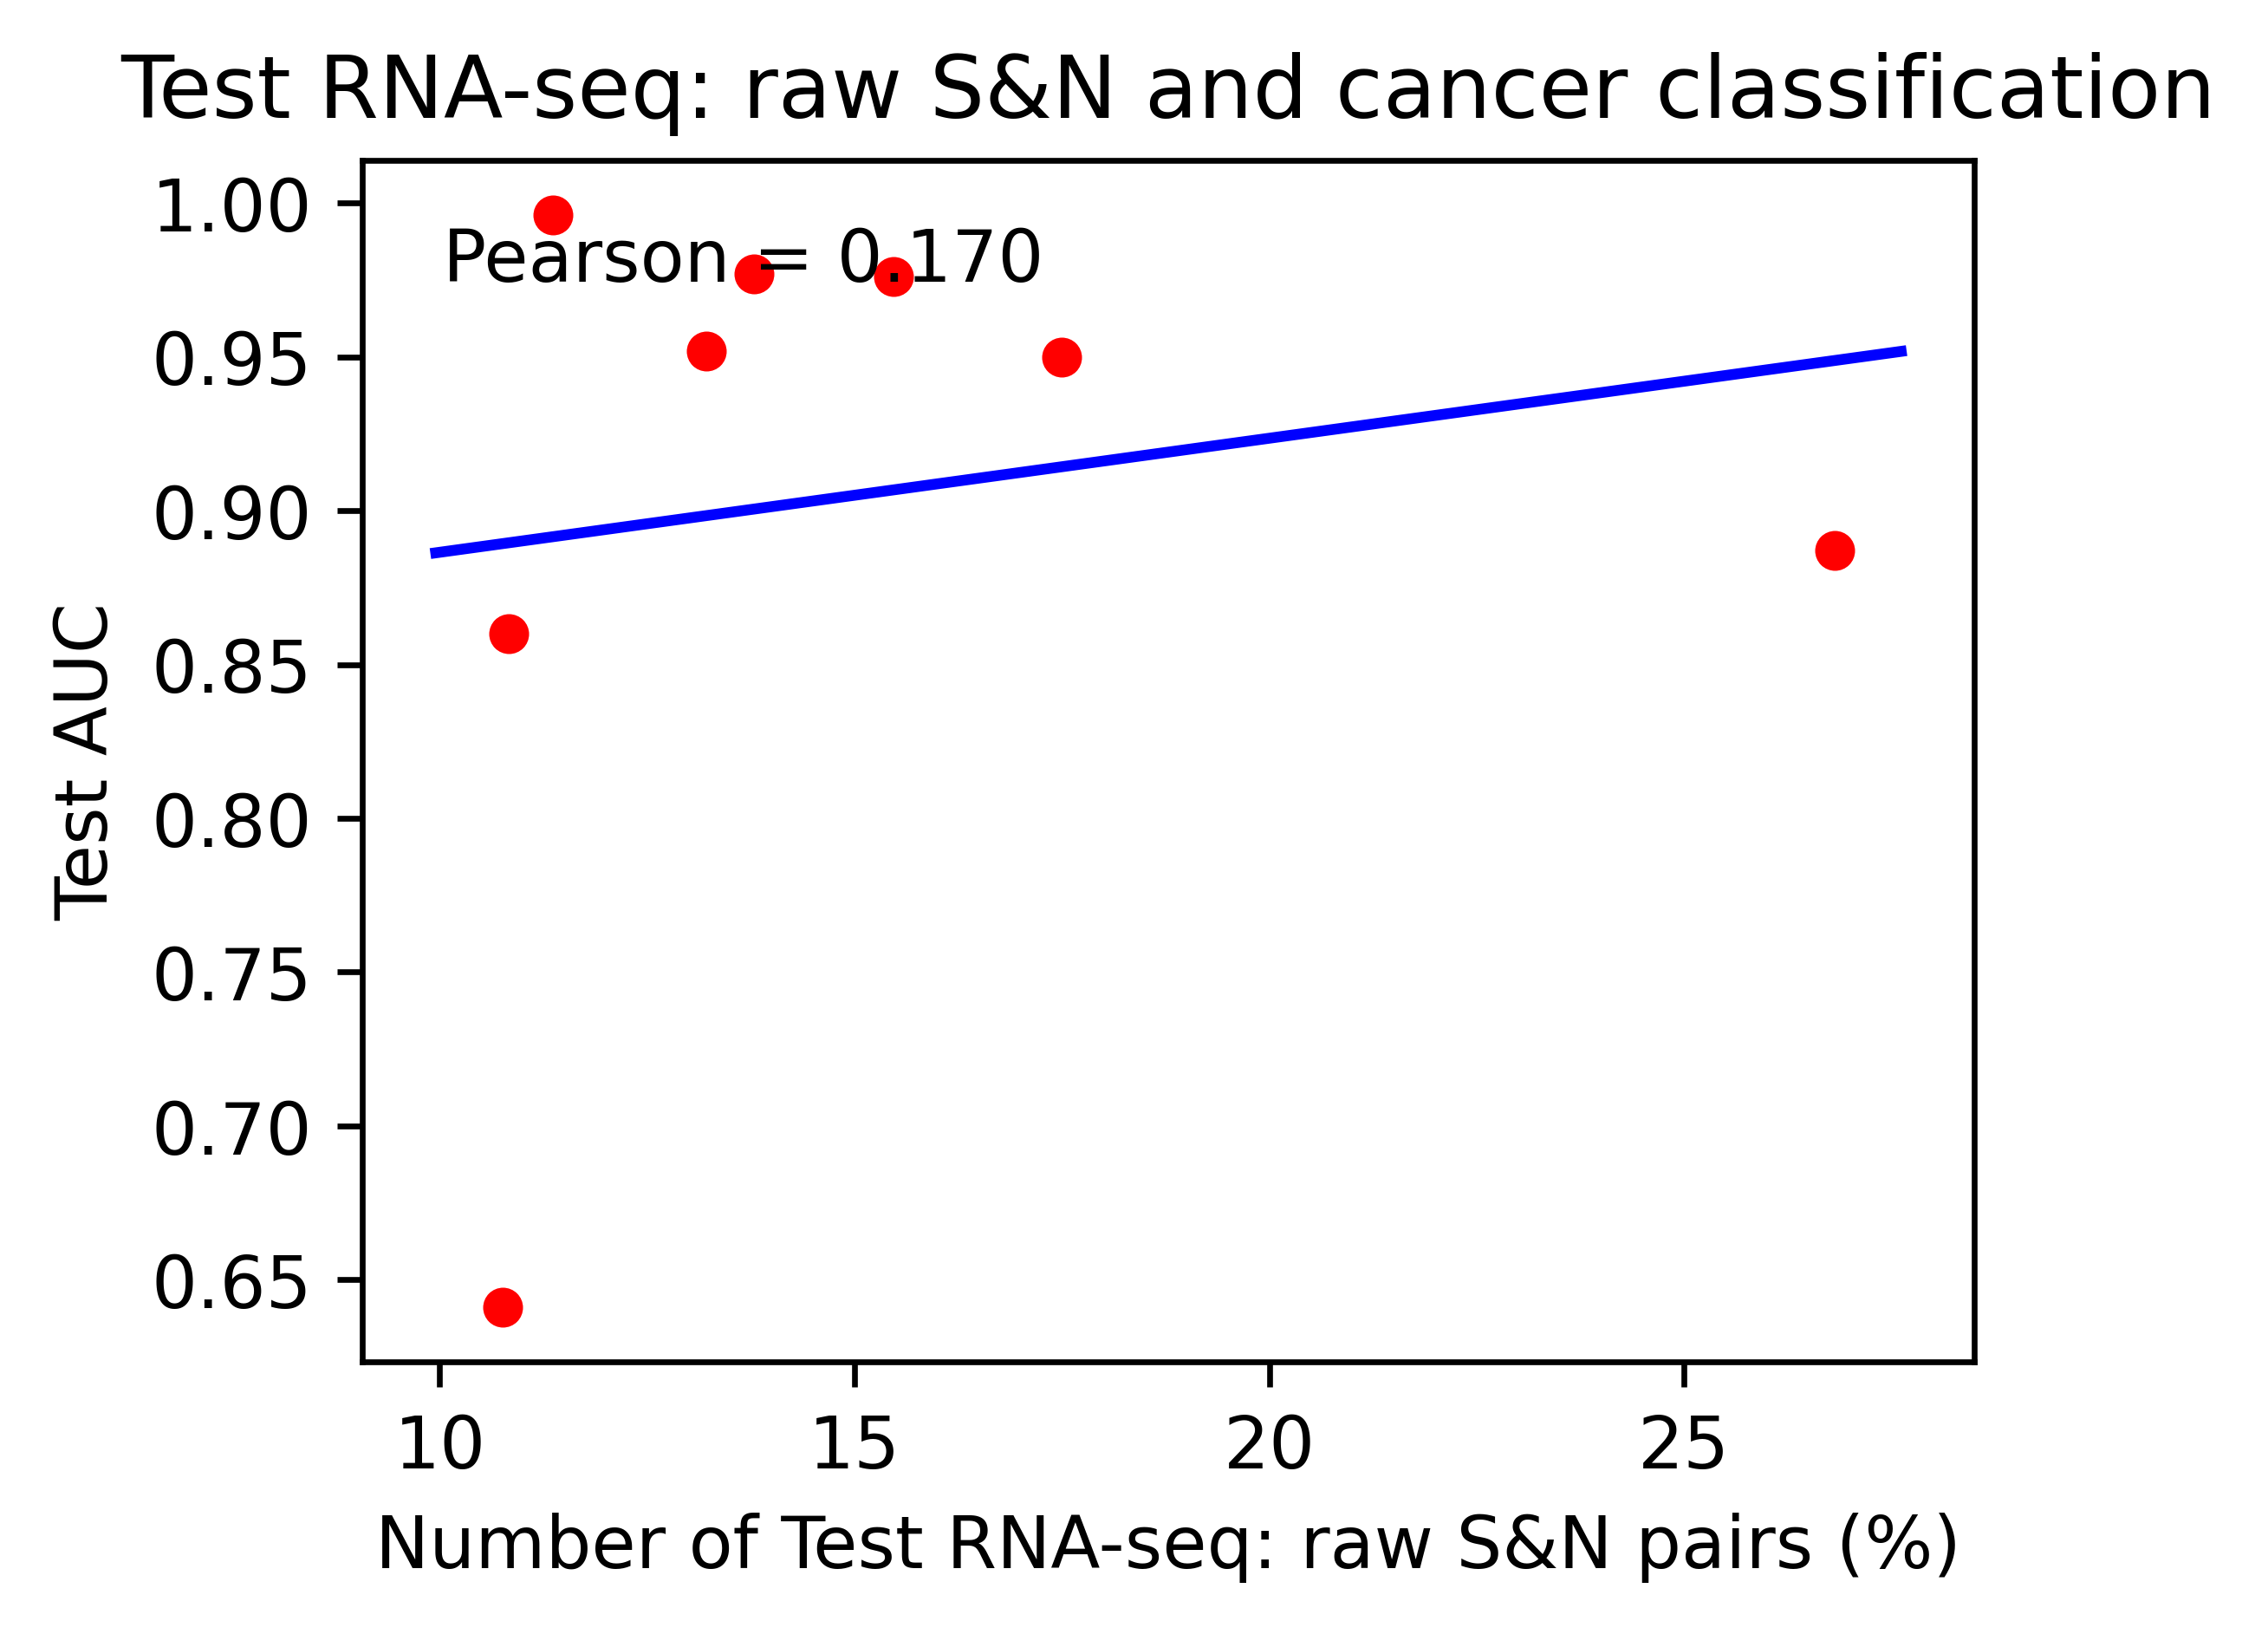

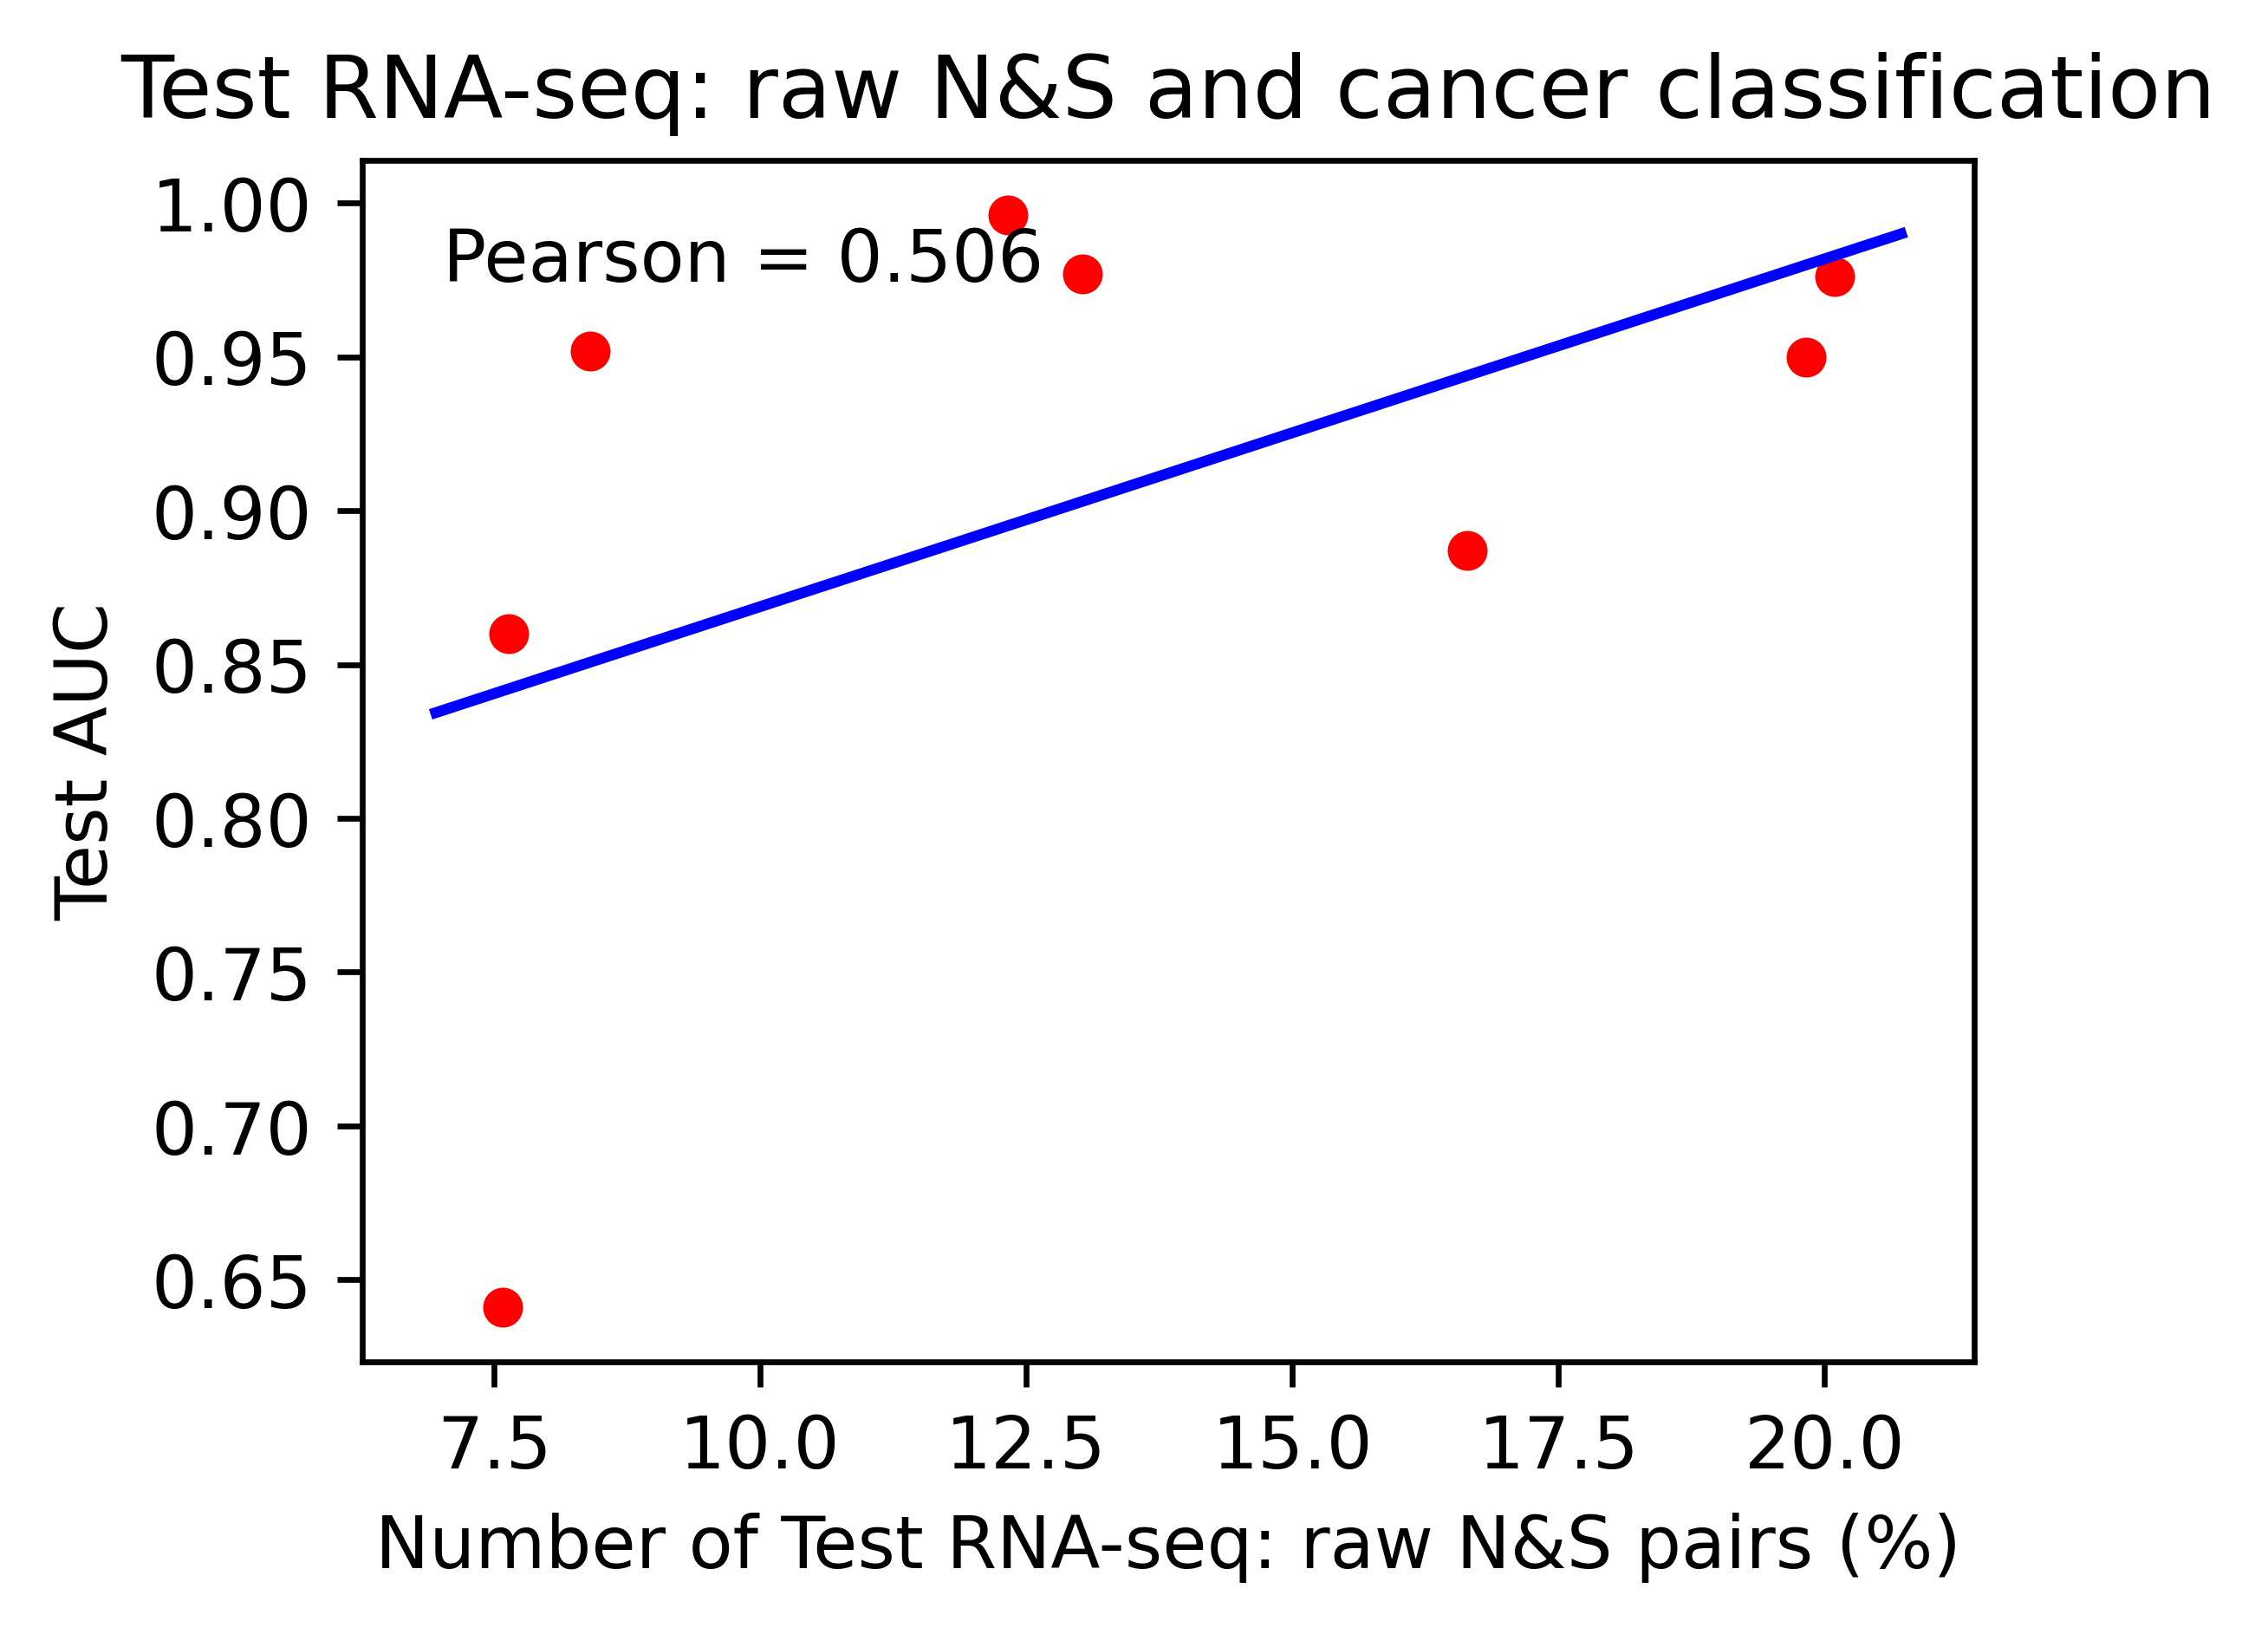

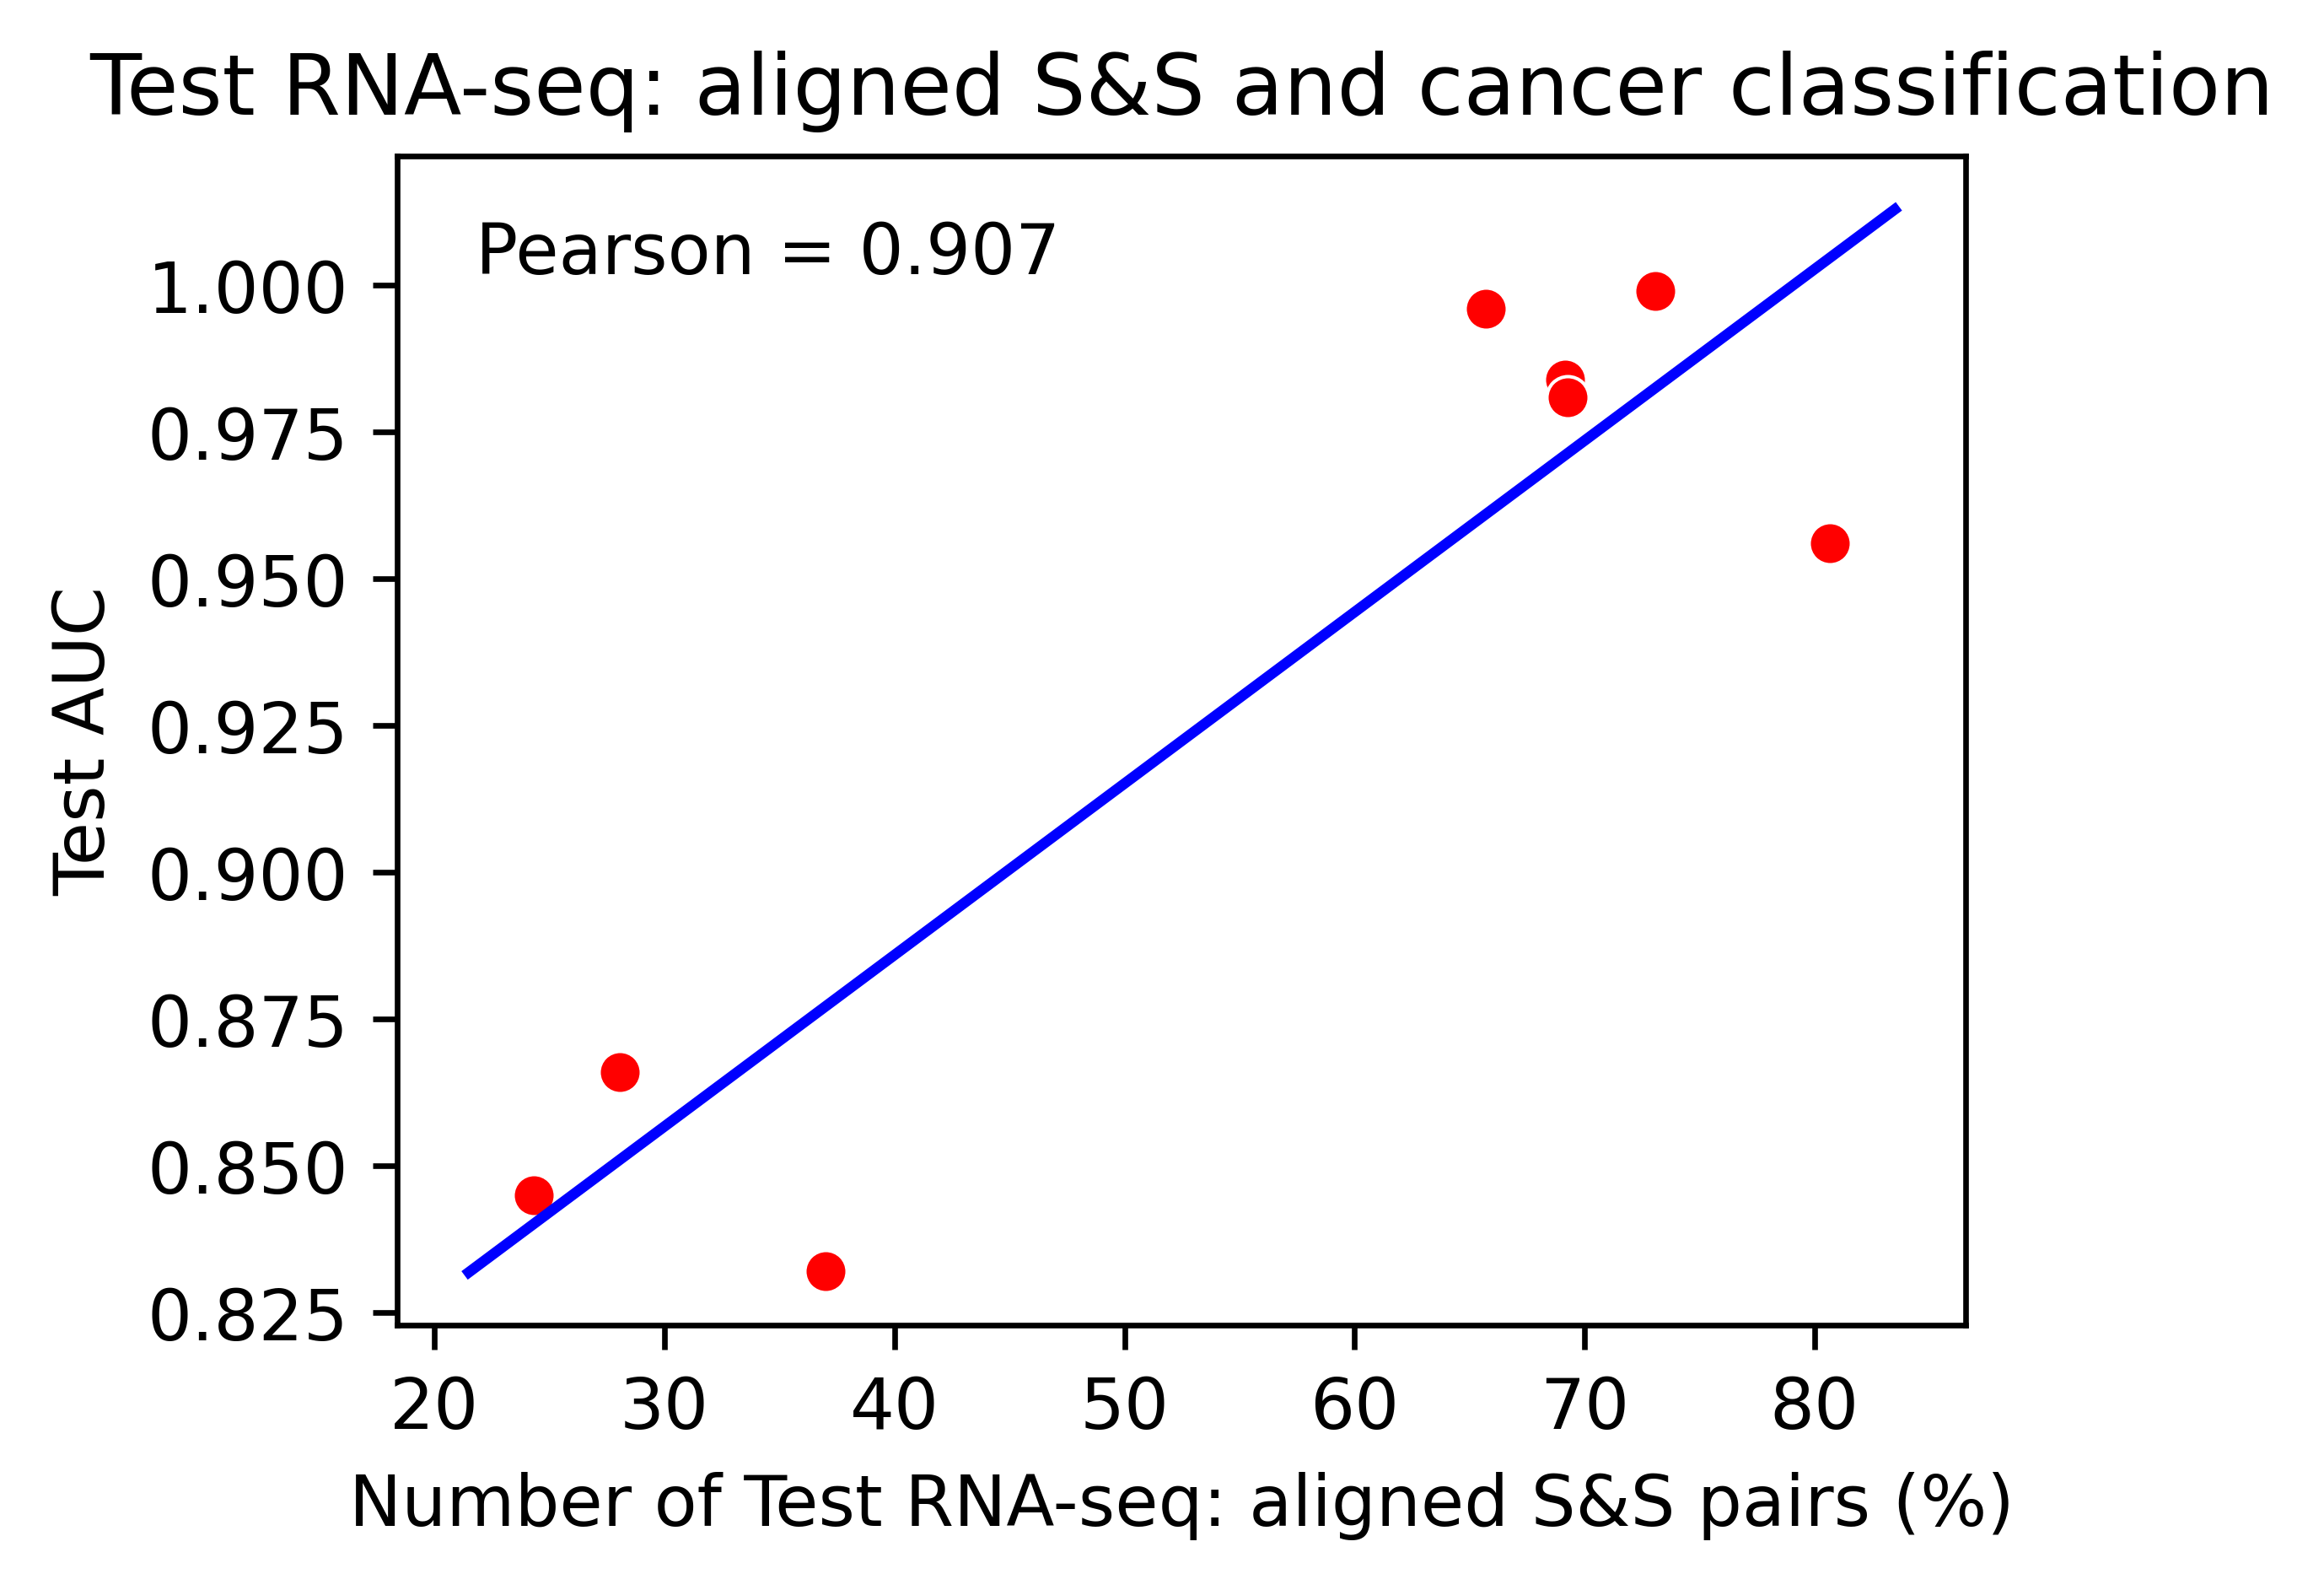

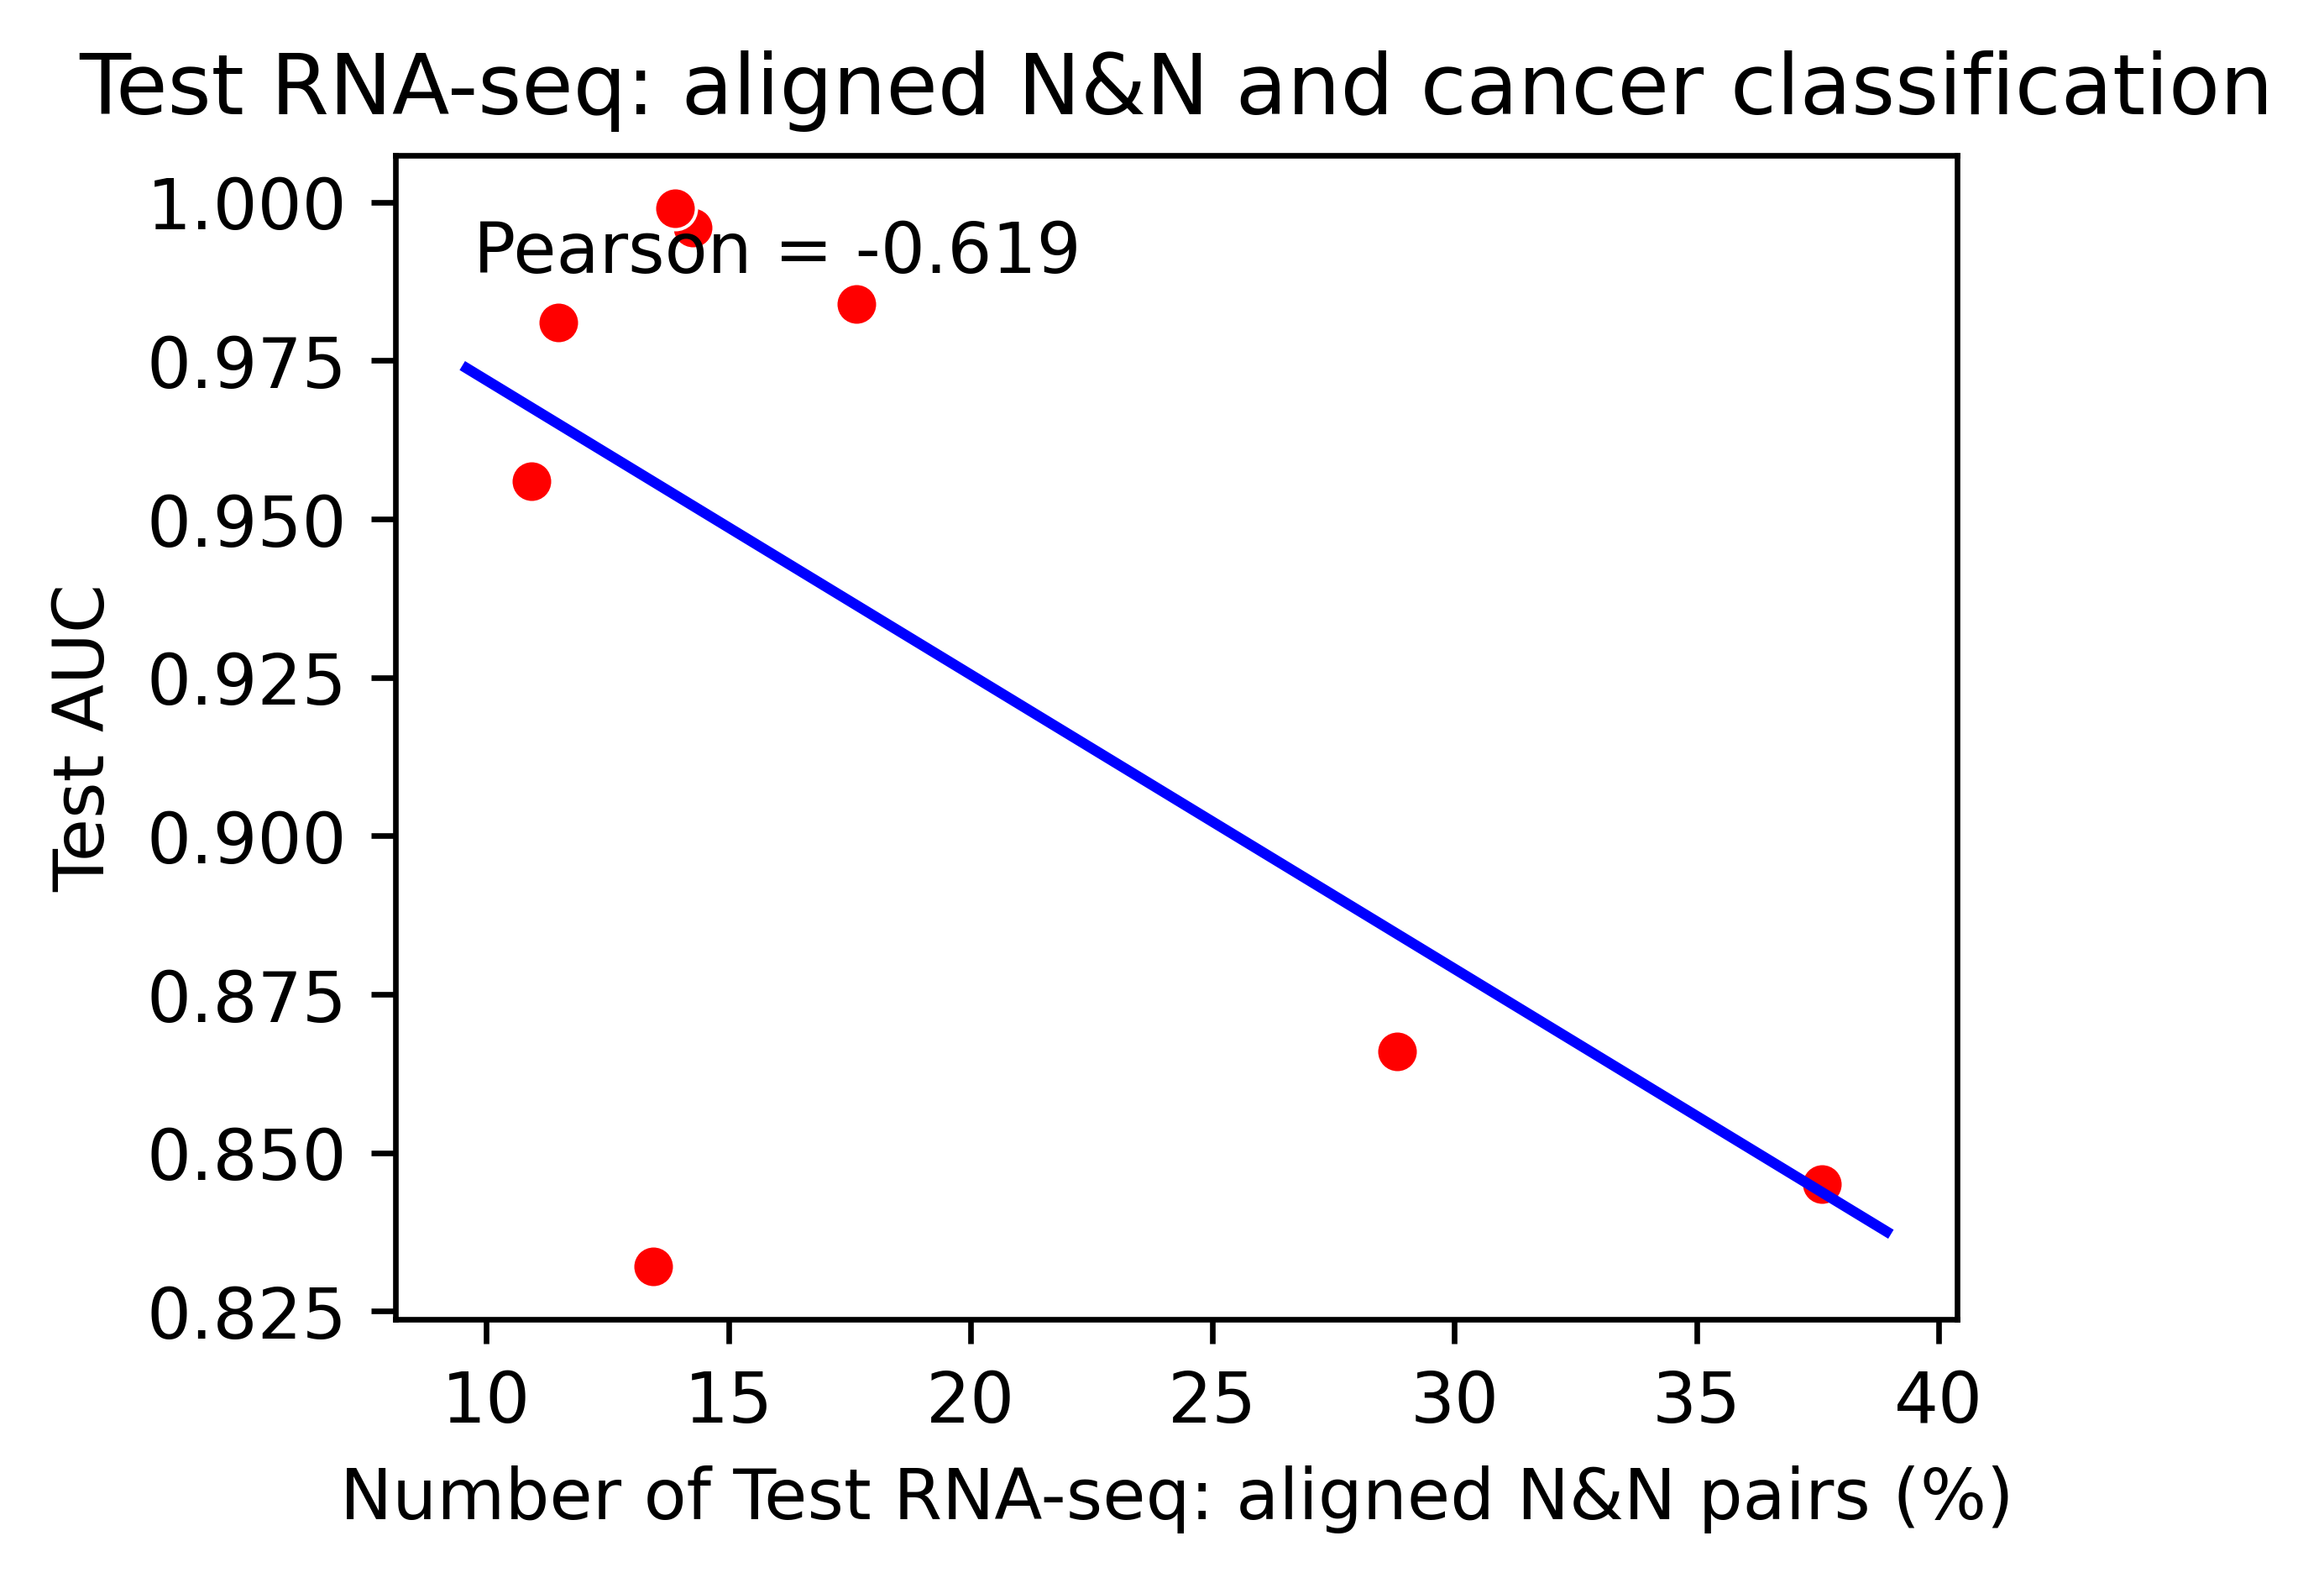

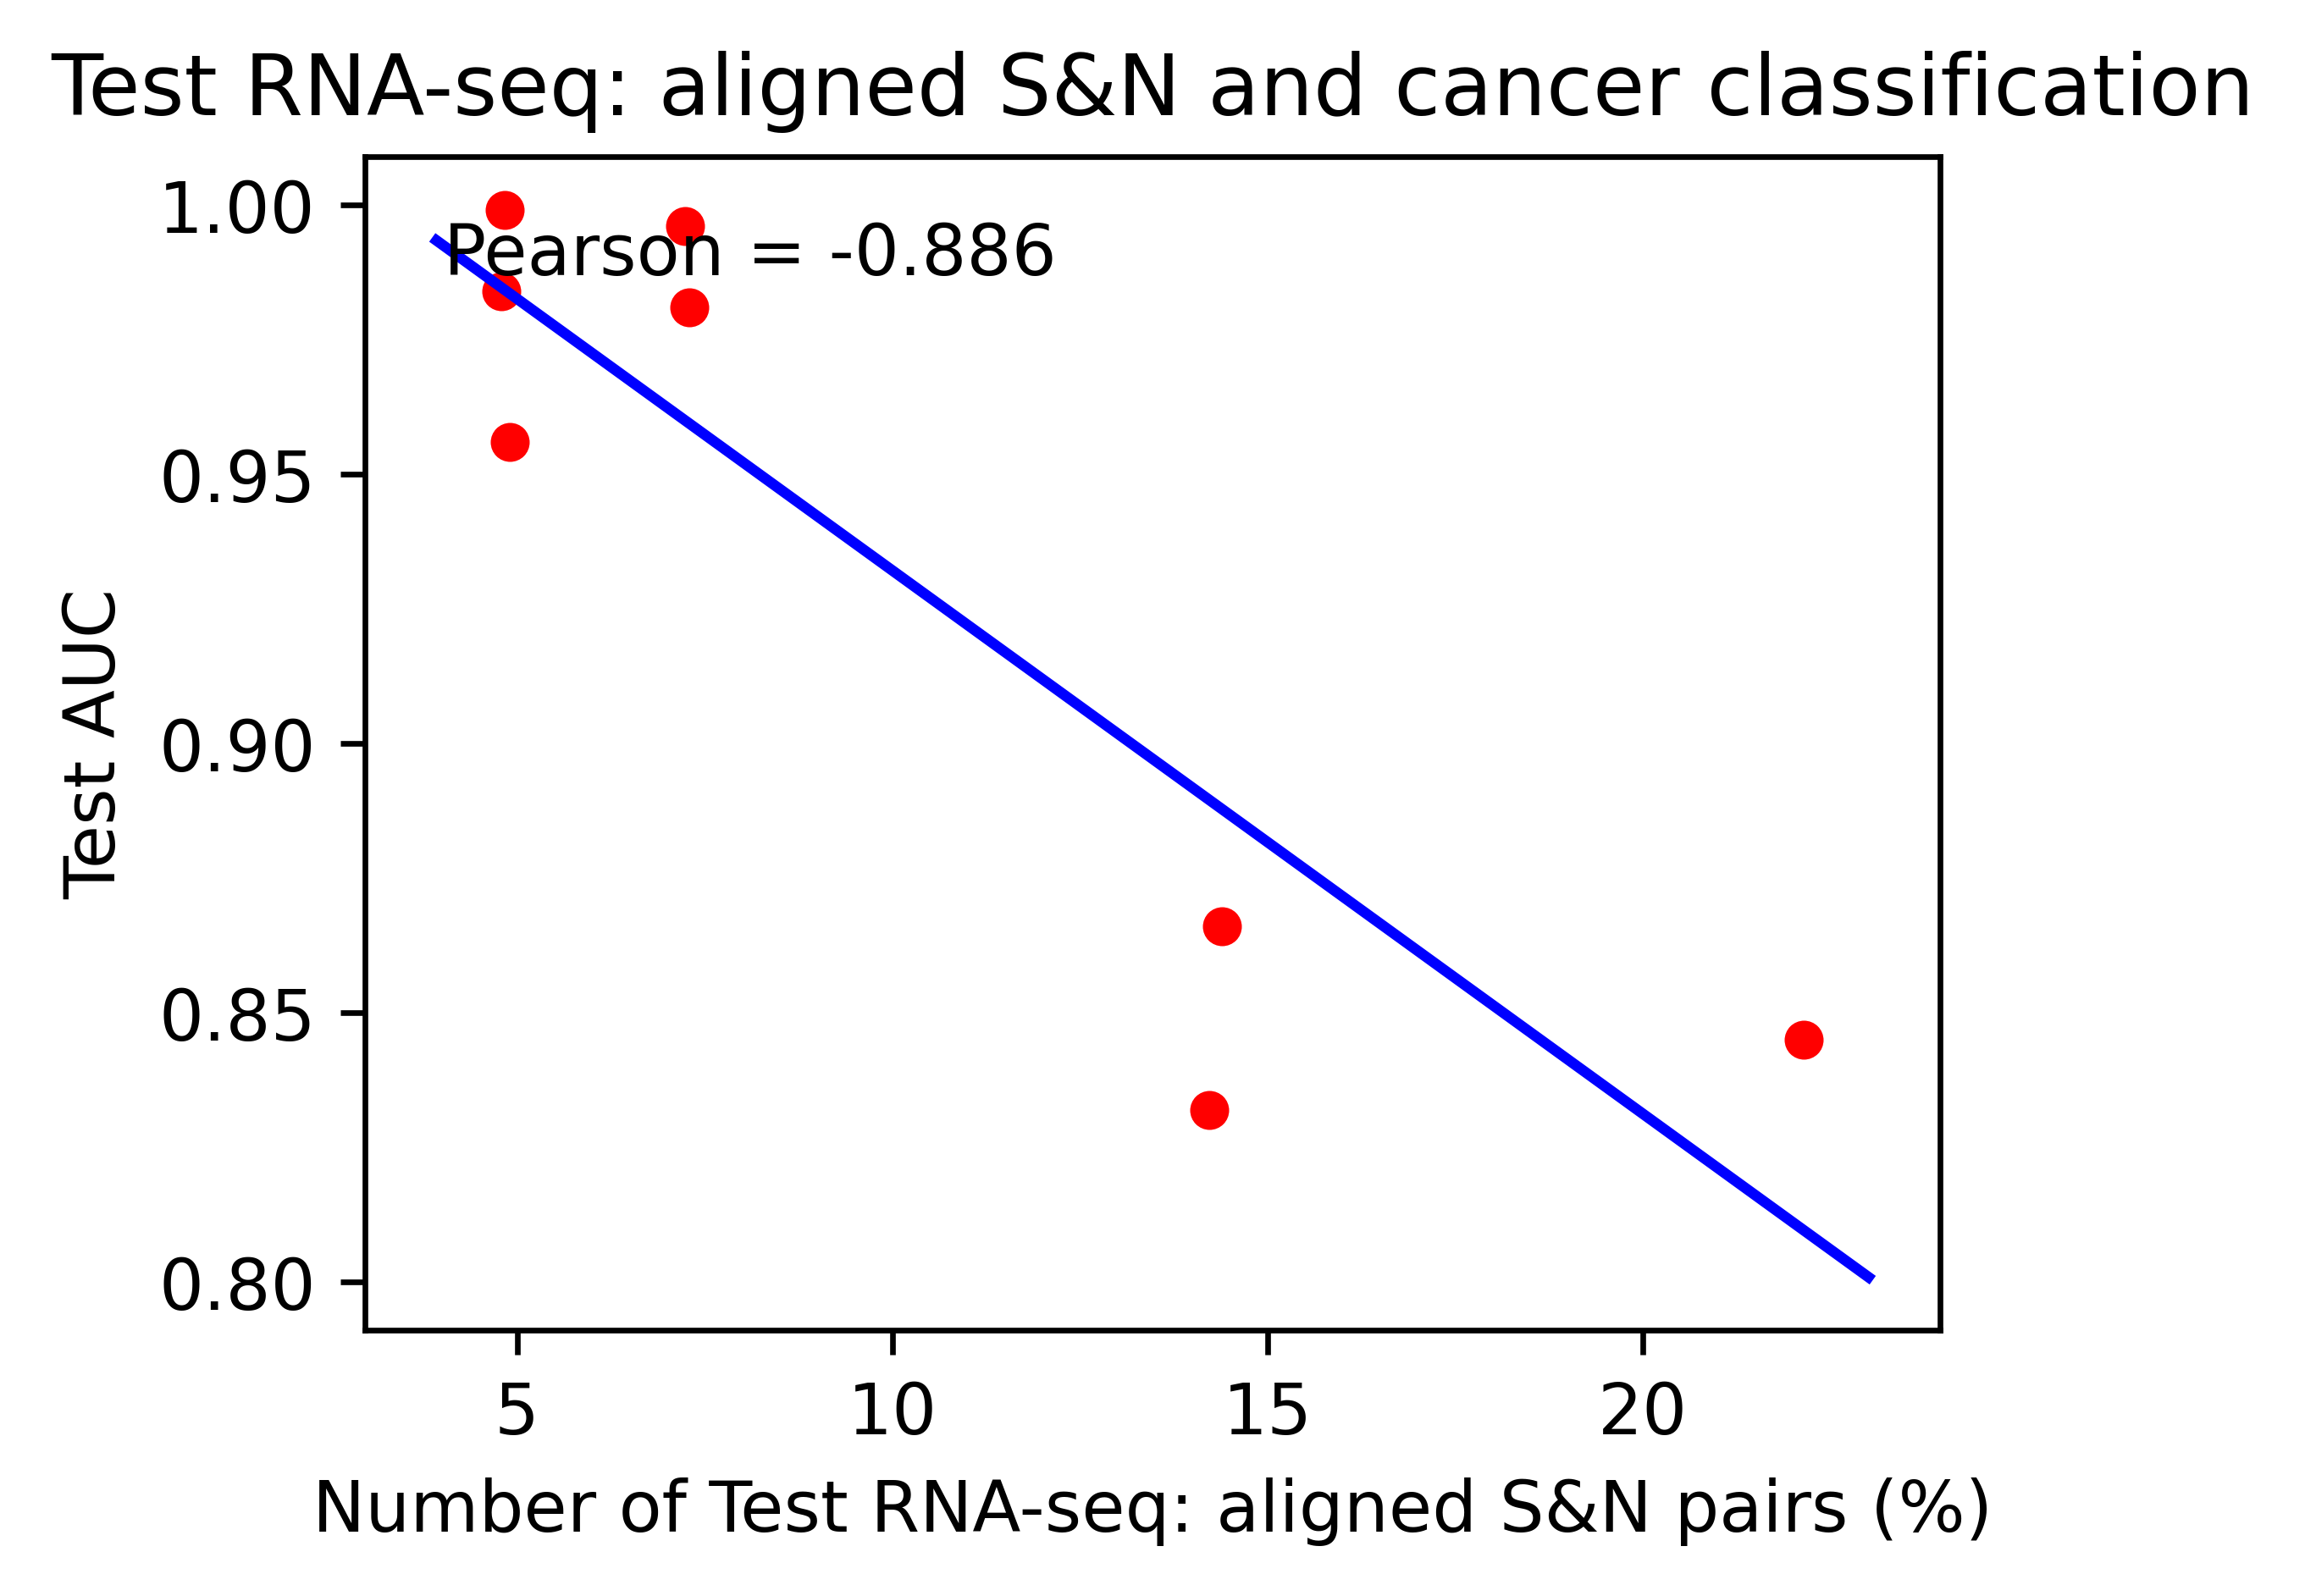

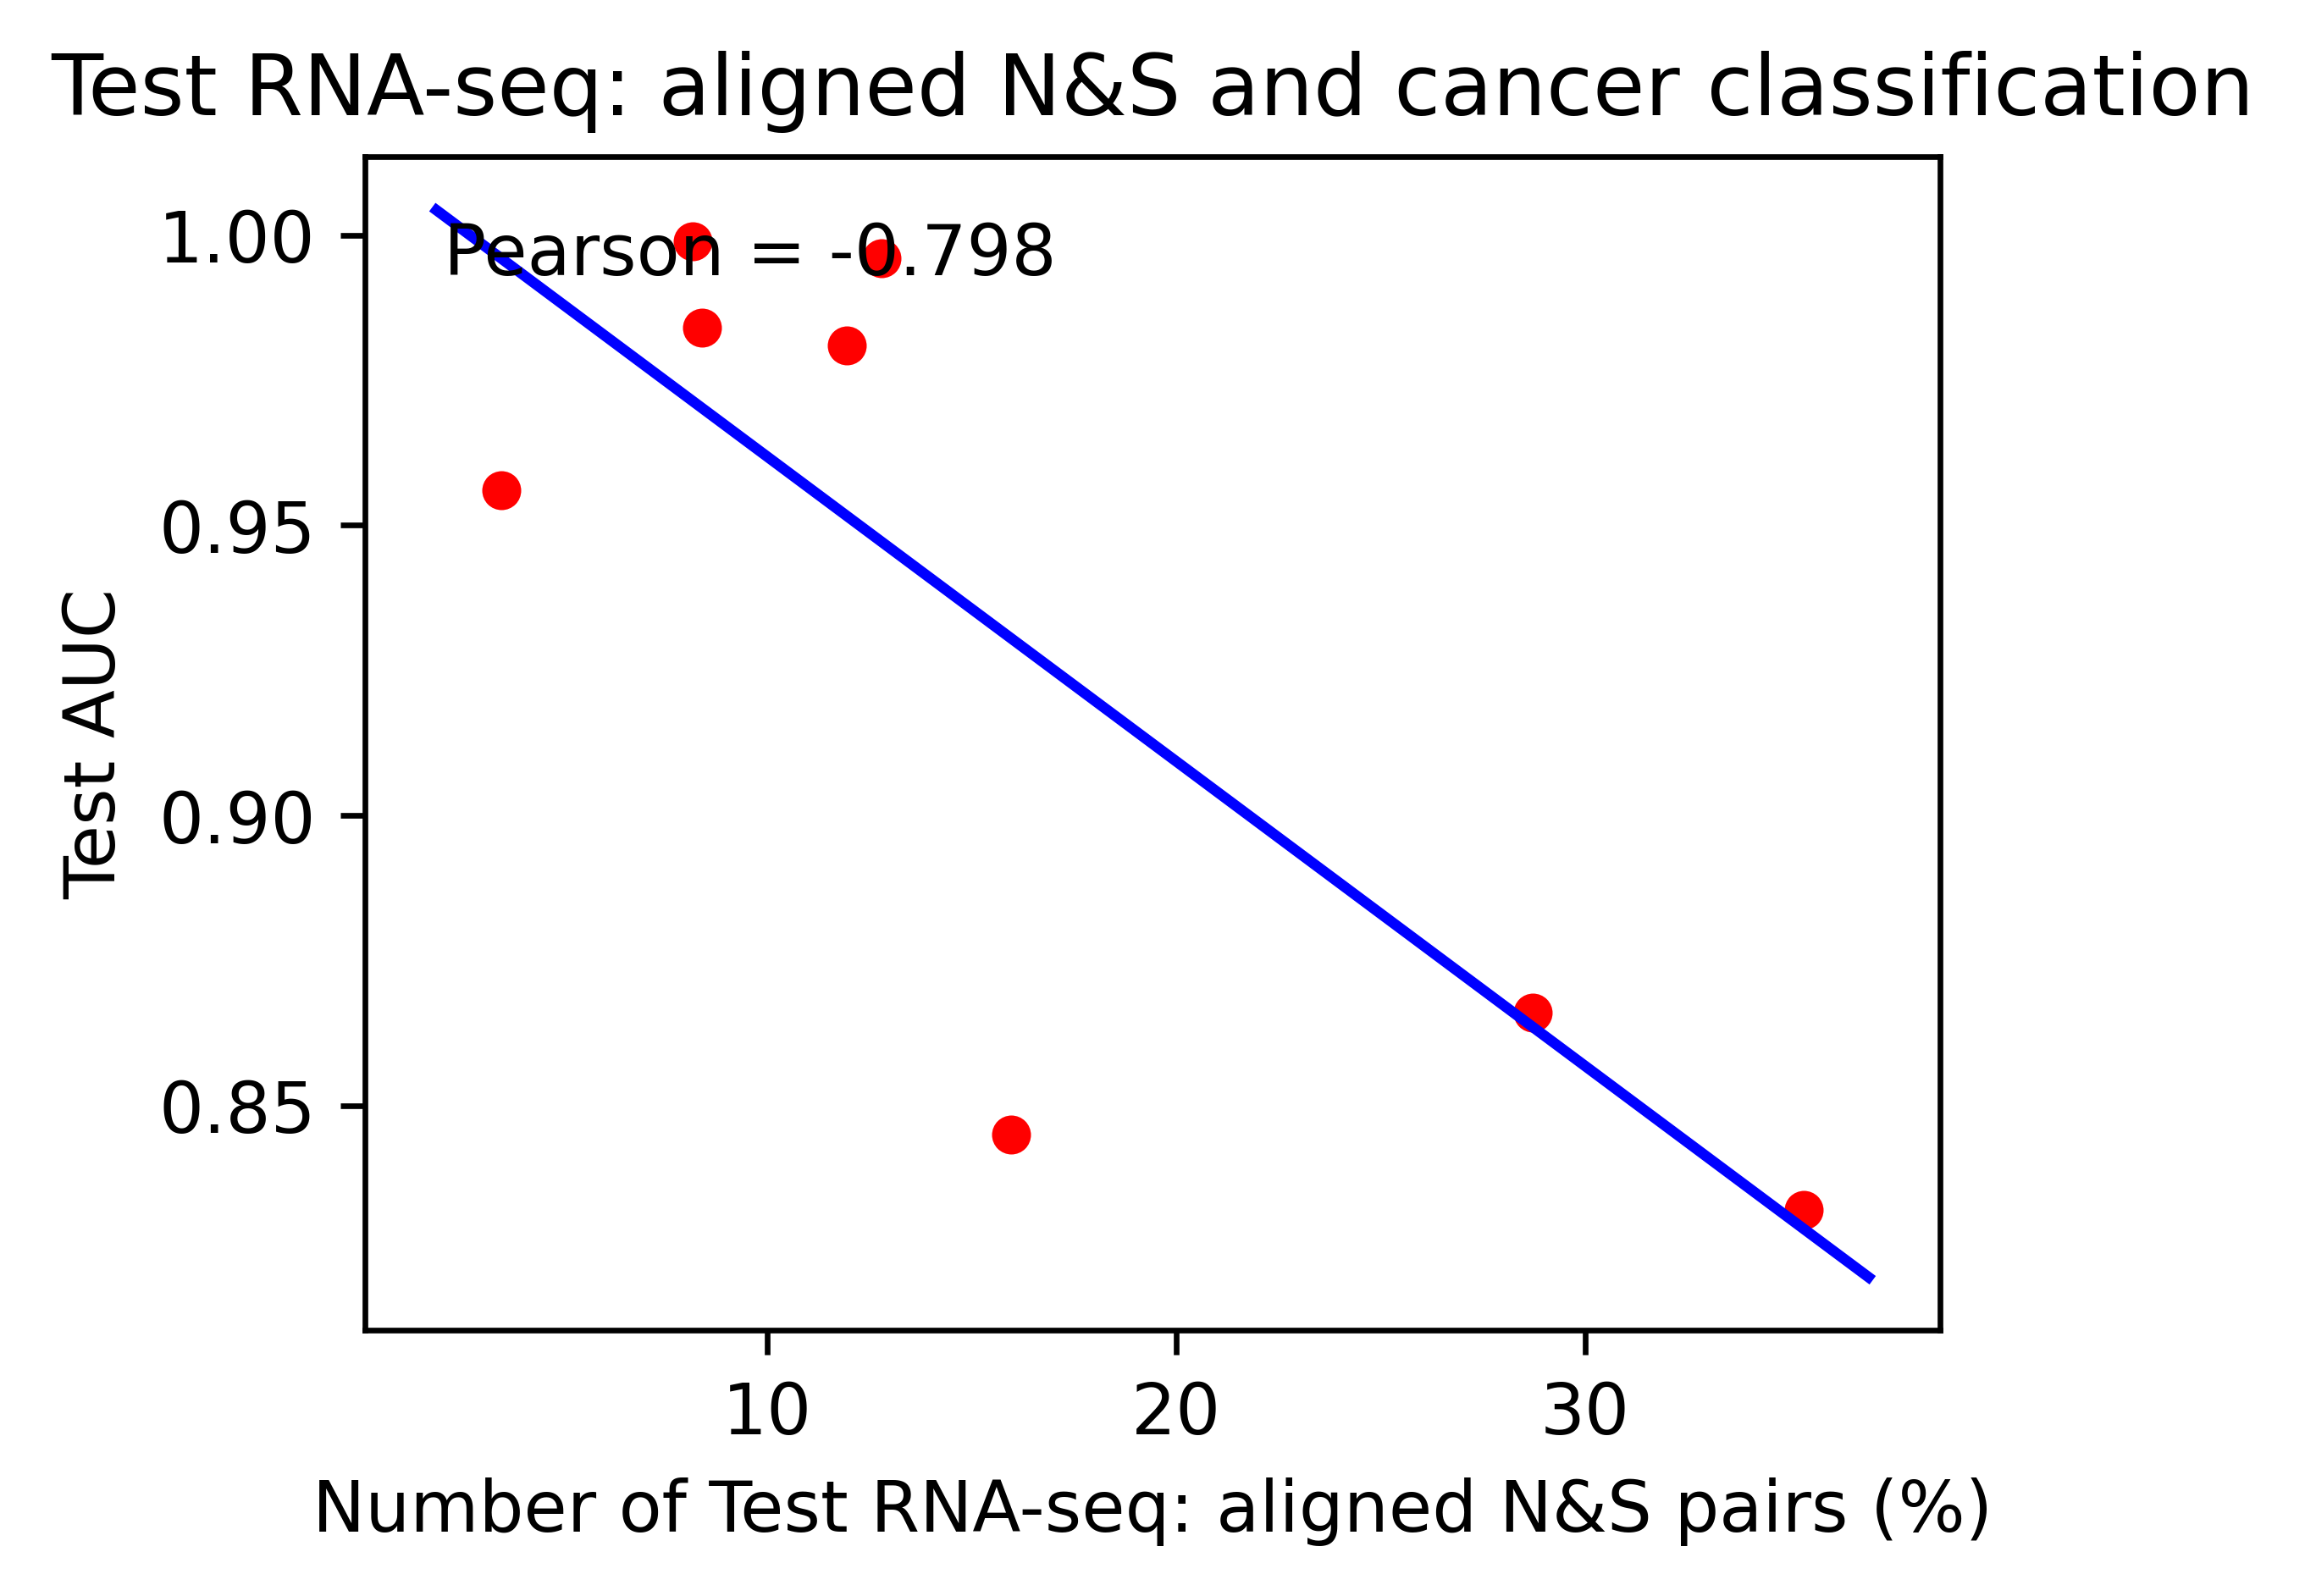

In [4]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
raw_auc_testrna_list = [raw_aucs_testrna[cancer] for cancer in cancers]
aligned_auc_testrna_list = [aligned_auc_testrna[cancer] for cancer in cancers]

raw_ss_list = [cancer_ss[cancer][0] for cancer in cancers]
raw_nn_list = [cancer_nn[cancer][0] for cancer in cancers]
raw_sn_list = [cancer_sn[cancer][0] for cancer in cancers]
raw_ns_list = [cancer_ns[cancer][0] for cancer in cancers]
aligned_ss_list = [cancer_ss[cancer][1] for cancer in cancers]
aligned_nn_list = [cancer_nn[cancer][1] for cancer in cancers]
aligned_sn_list = [cancer_sn[cancer][1] for cancer in cancers]
aligned_ns_list = [cancer_ns[cancer][1] for cancer in cancers]

### correlation between significance pairs and test auc
def plot_correlation(x_data, y_data, marker):
    fig = plt.figure(dpi = 600, figsize = (4, 3))
    sns.scatterplot(x = x_data, y = y_data, color = "red")
    plt.title("{} and cancer classification".format(marker))
    plt.ylabel("Test AUC")
    plt.xlabel("Number of {} pairs (%)".format(marker))
    r, p = pearsonr(x_data, y_data)
    r2 = r2_score(x_data, y_data)
    ax = plt.gca() # Get a matplotlib's axes instance
#     plt.text(.05, .9, "R^2 = {:.3f}".format(r2), transform=ax.transAxes)
    plt.text(.05, .9, "Pearson = {:.3f}".format(r), transform=ax.transAxes)
    m, b = np.polyfit(x_data, y_data, 1)
    X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, "-", color = "blue")
    plt.savefig(os.path.join(out_dir, '{} and clf.png'.format(marker)), bbox_inches='tight')
plot_correlation(raw_ss_list, raw_auc_testrna_list, "Test RNA-seq: raw S&S")
plot_correlation(raw_nn_list, raw_auc_testrna_list, "Test RNA-seq: raw N&N")
plot_correlation(raw_sn_list, raw_auc_testrna_list, "Test RNA-seq: raw S&N")
plot_correlation(raw_ns_list, raw_auc_testrna_list, "Test RNA-seq: raw N&S")
plot_correlation(aligned_ss_list, aligned_auc_testrna_list, "Test RNA-seq: aligned S&S")
plot_correlation(aligned_nn_list, aligned_auc_testrna_list, "Test RNA-seq: aligned N&N")
plot_correlation(aligned_sn_list, aligned_auc_testrna_list, "Test RNA-seq: aligned S&N")
plot_correlation(aligned_ns_list, aligned_auc_testrna_list, "Test RNA-seq: aligned N&S")


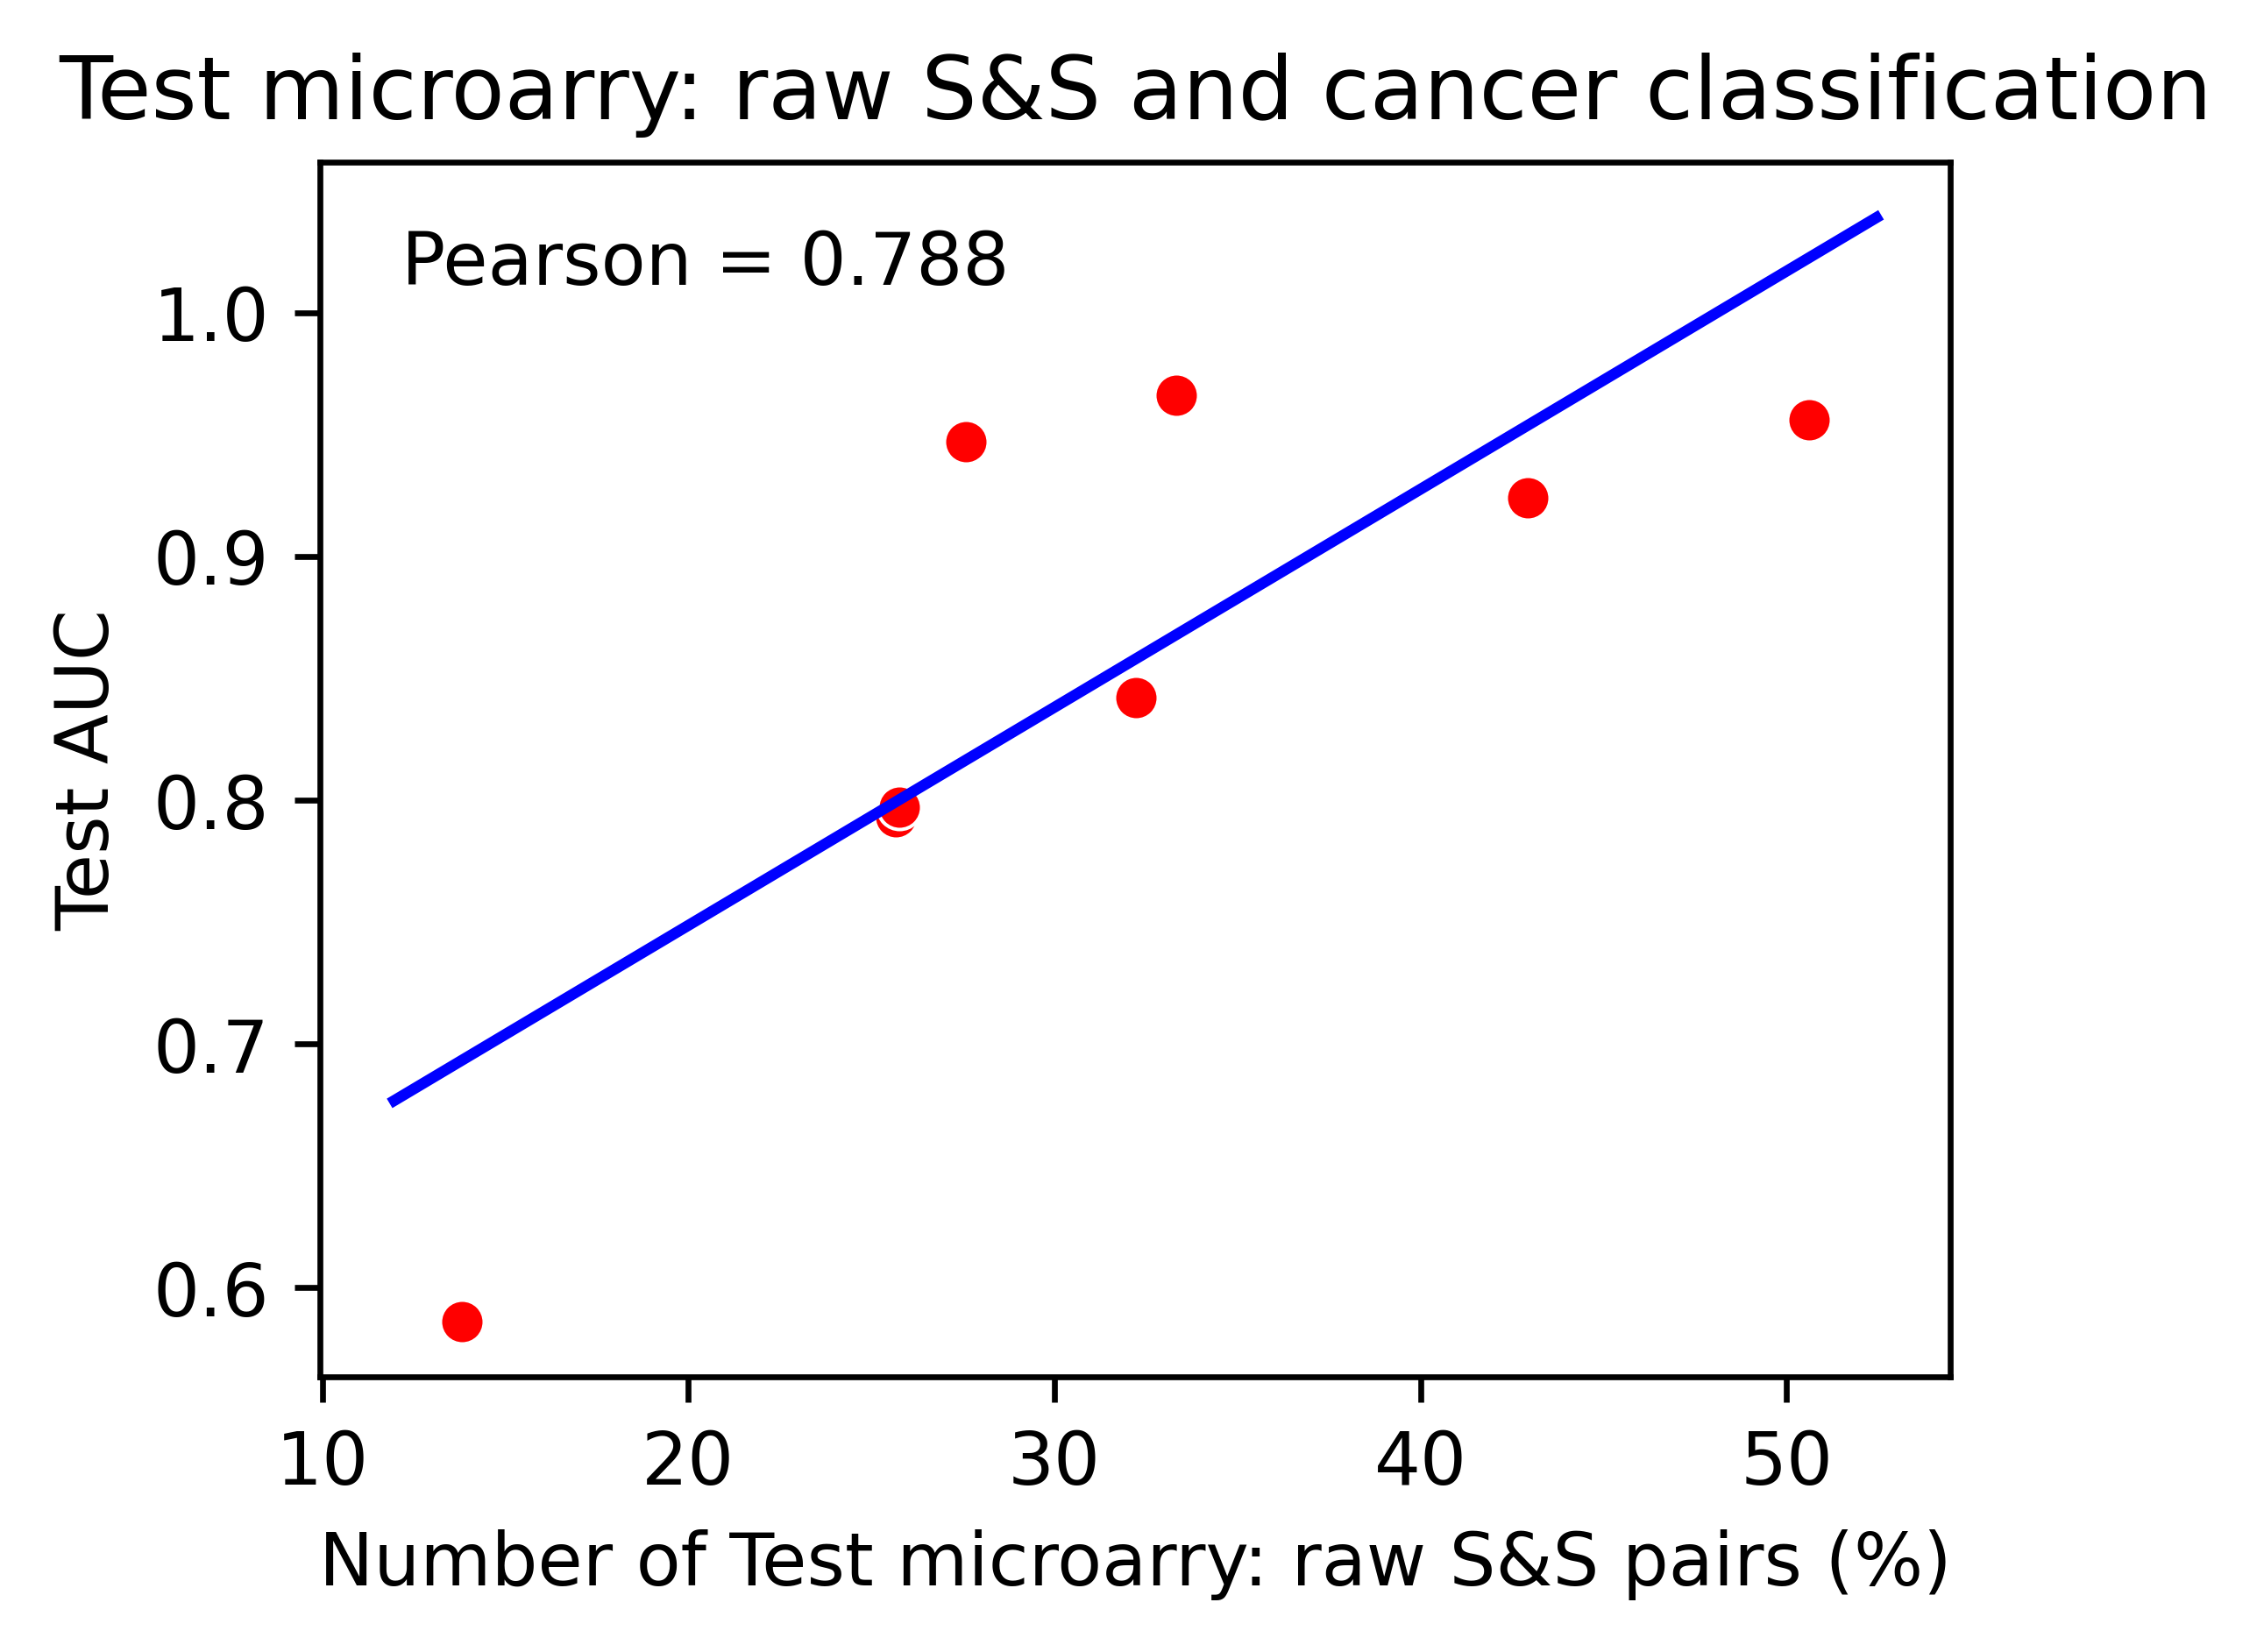

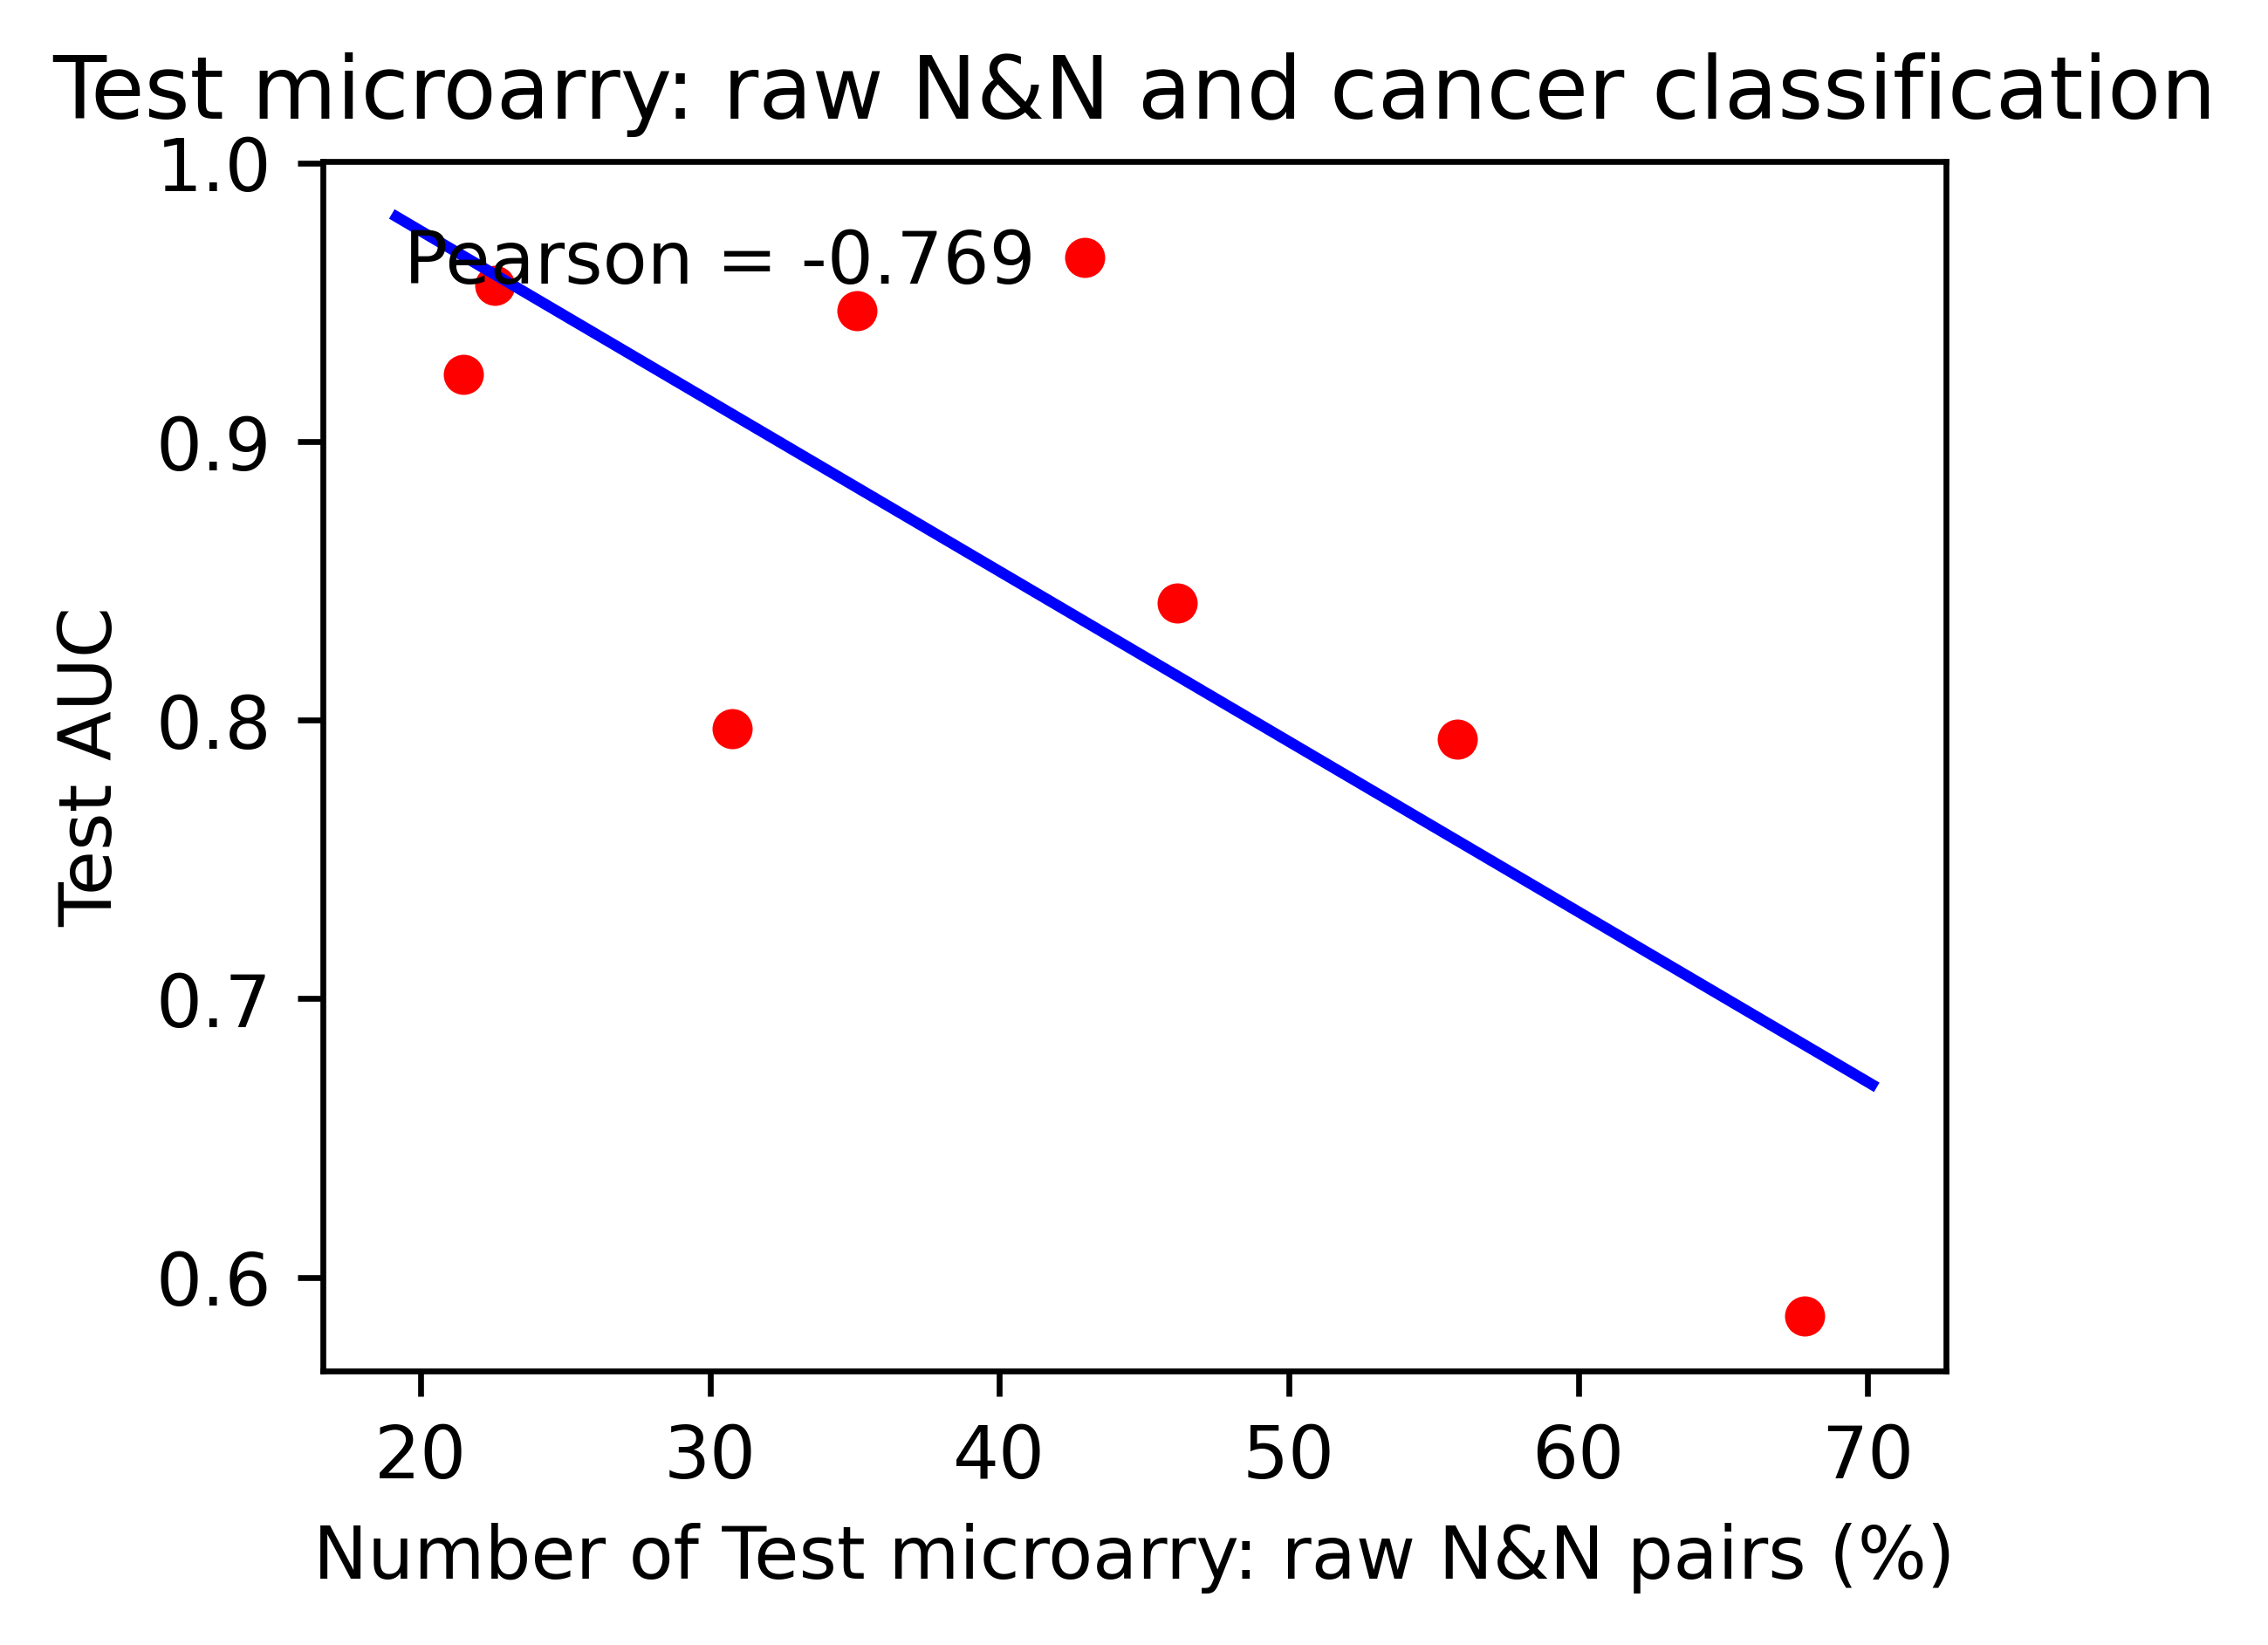

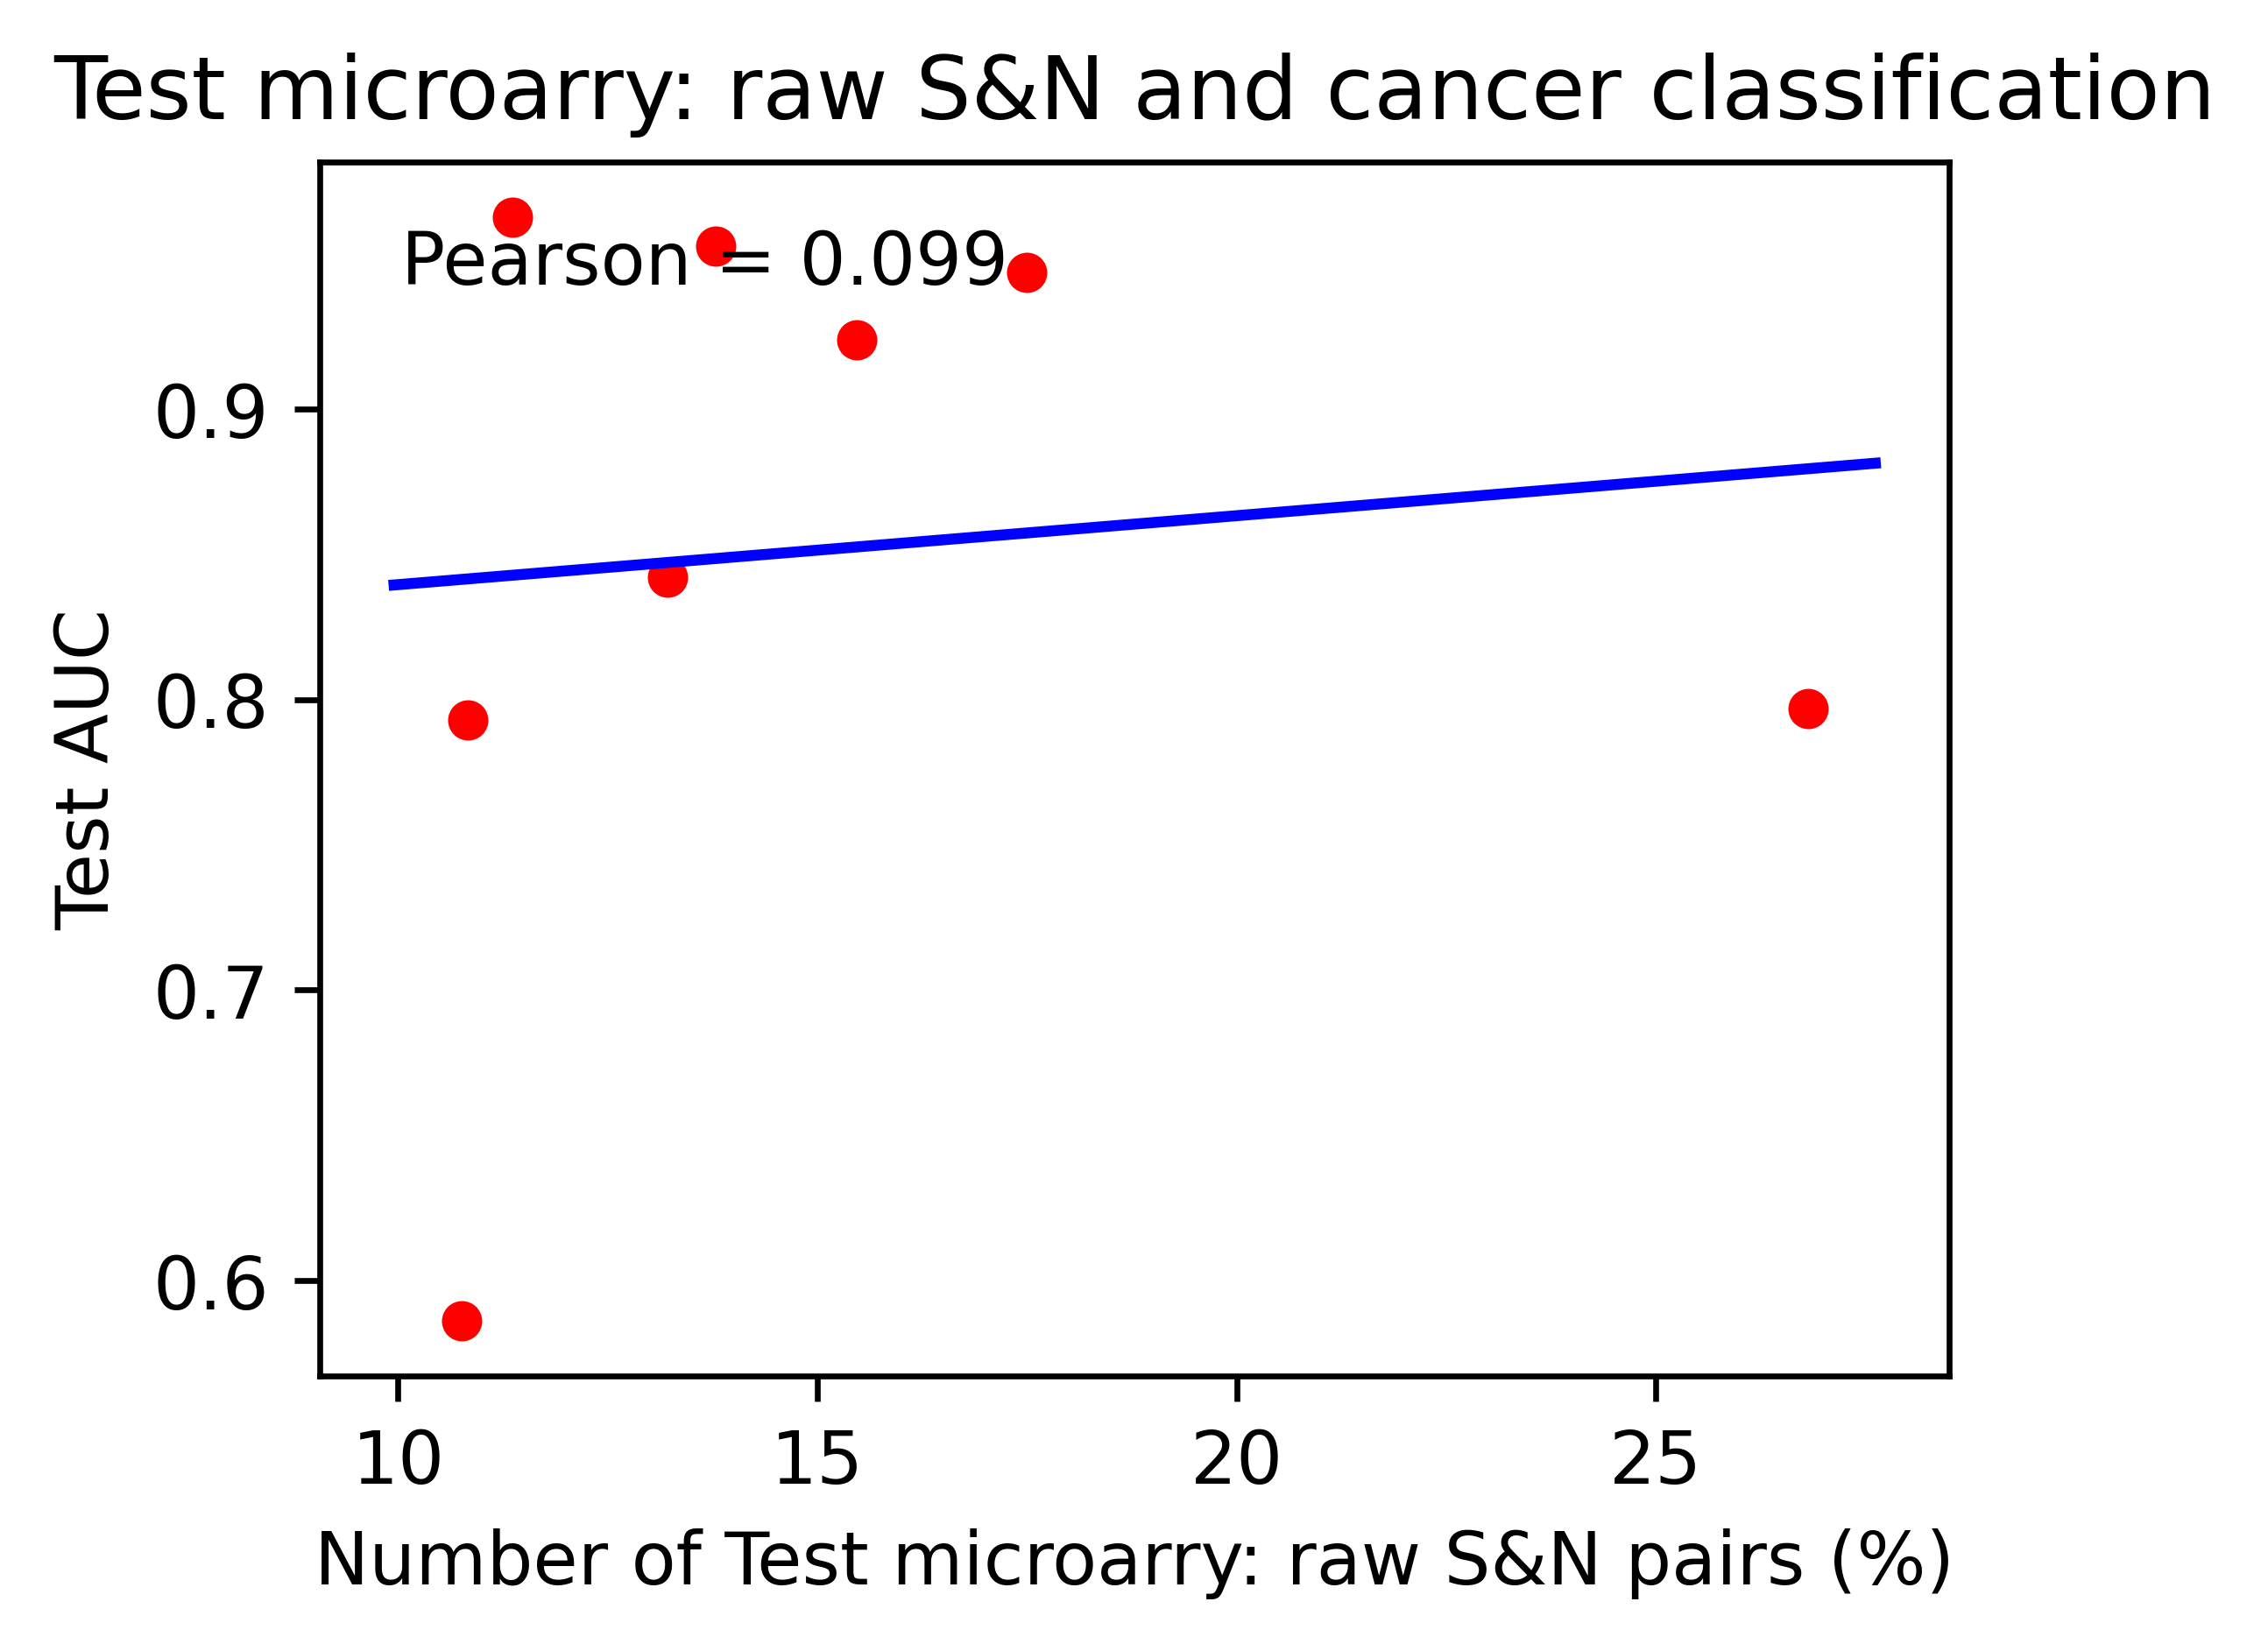

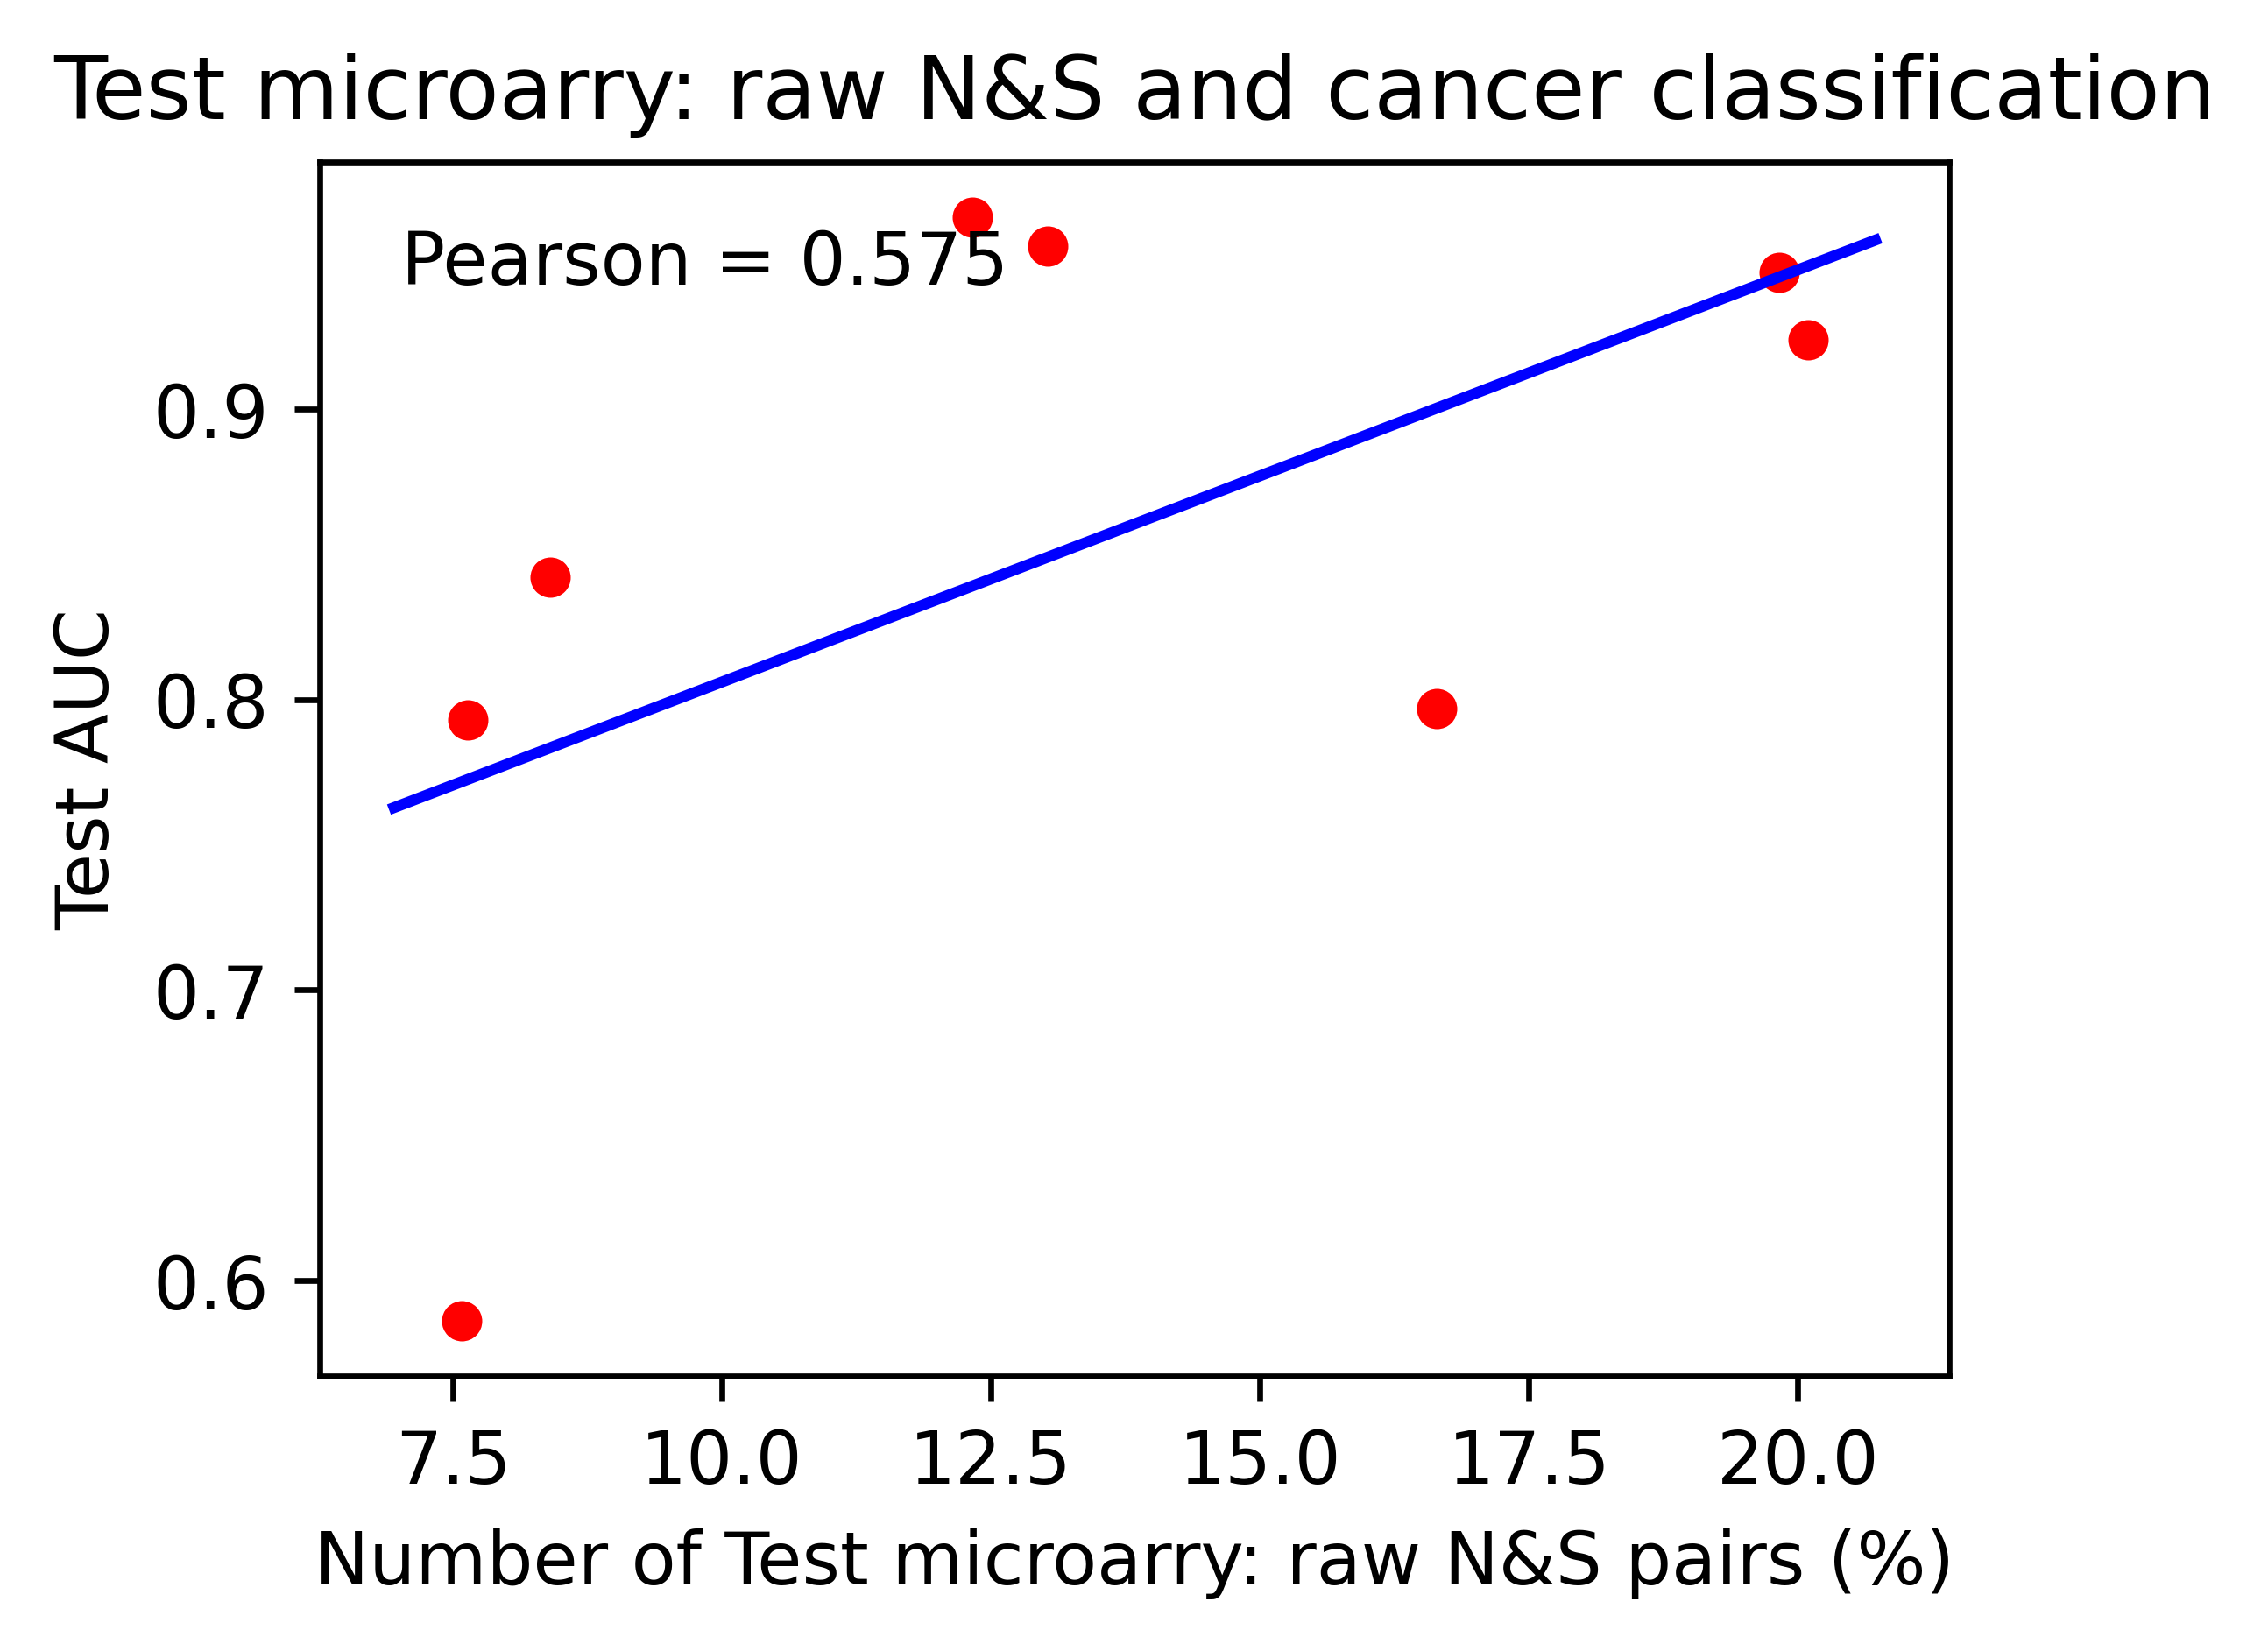

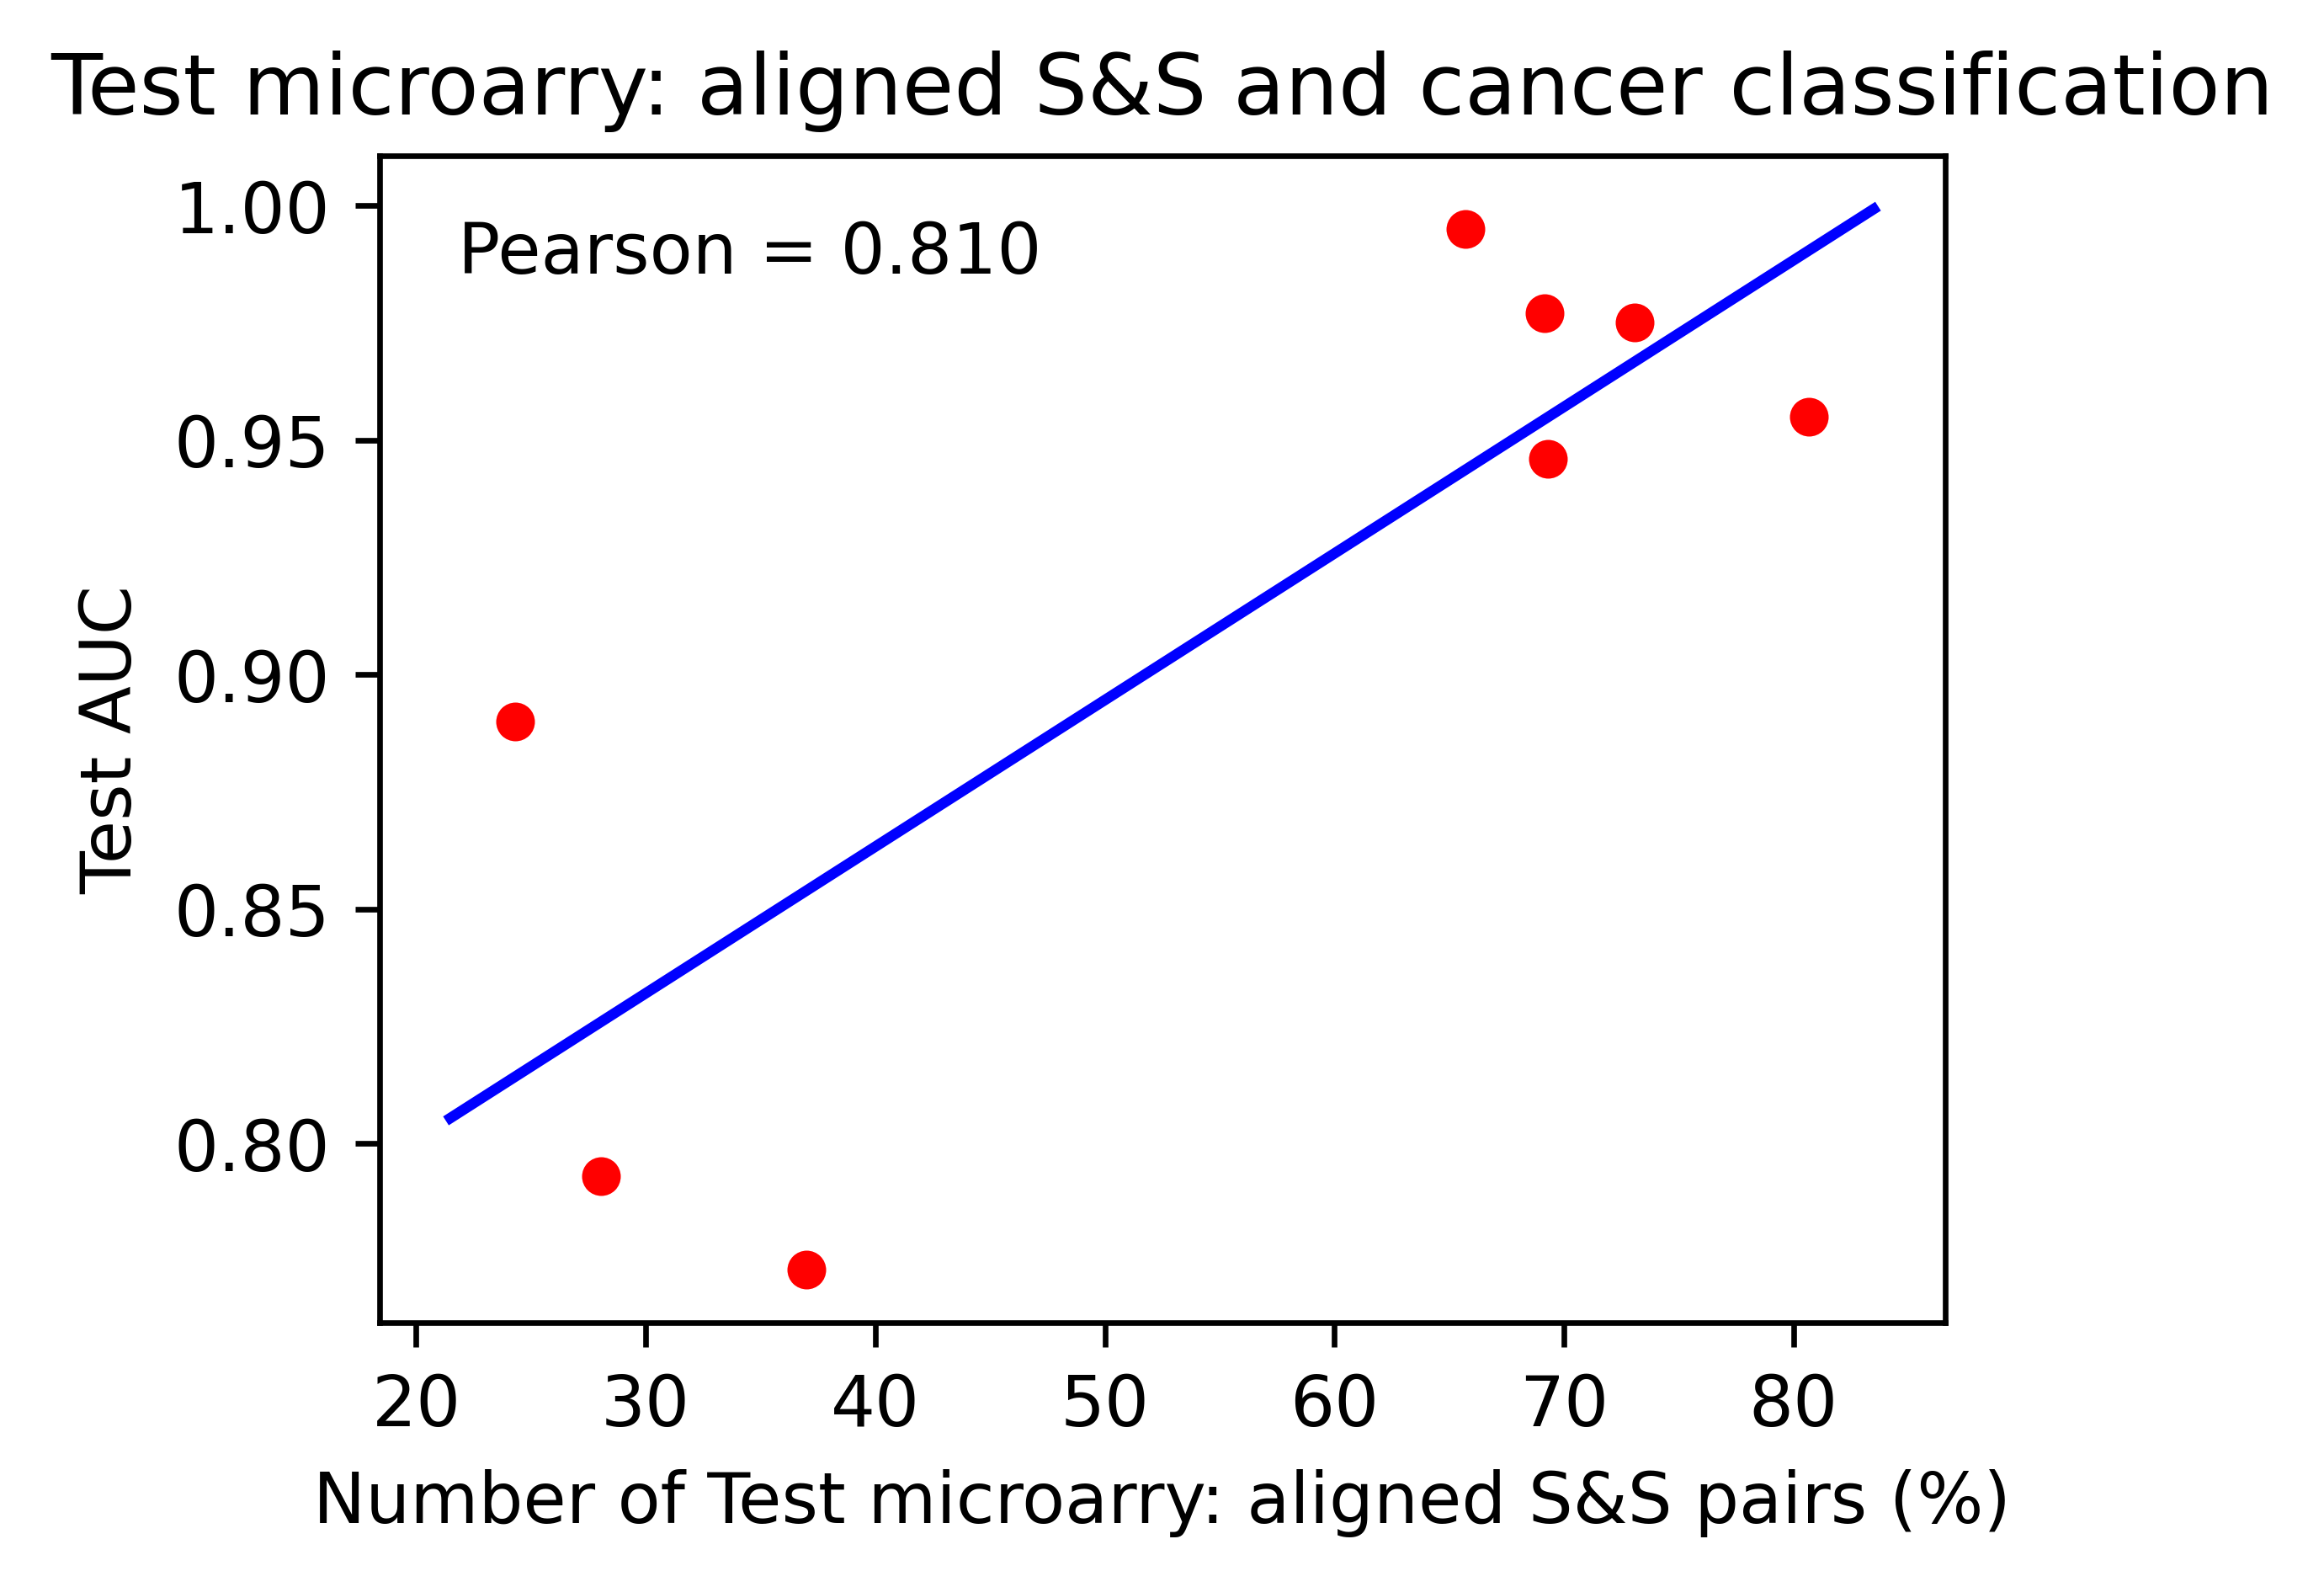

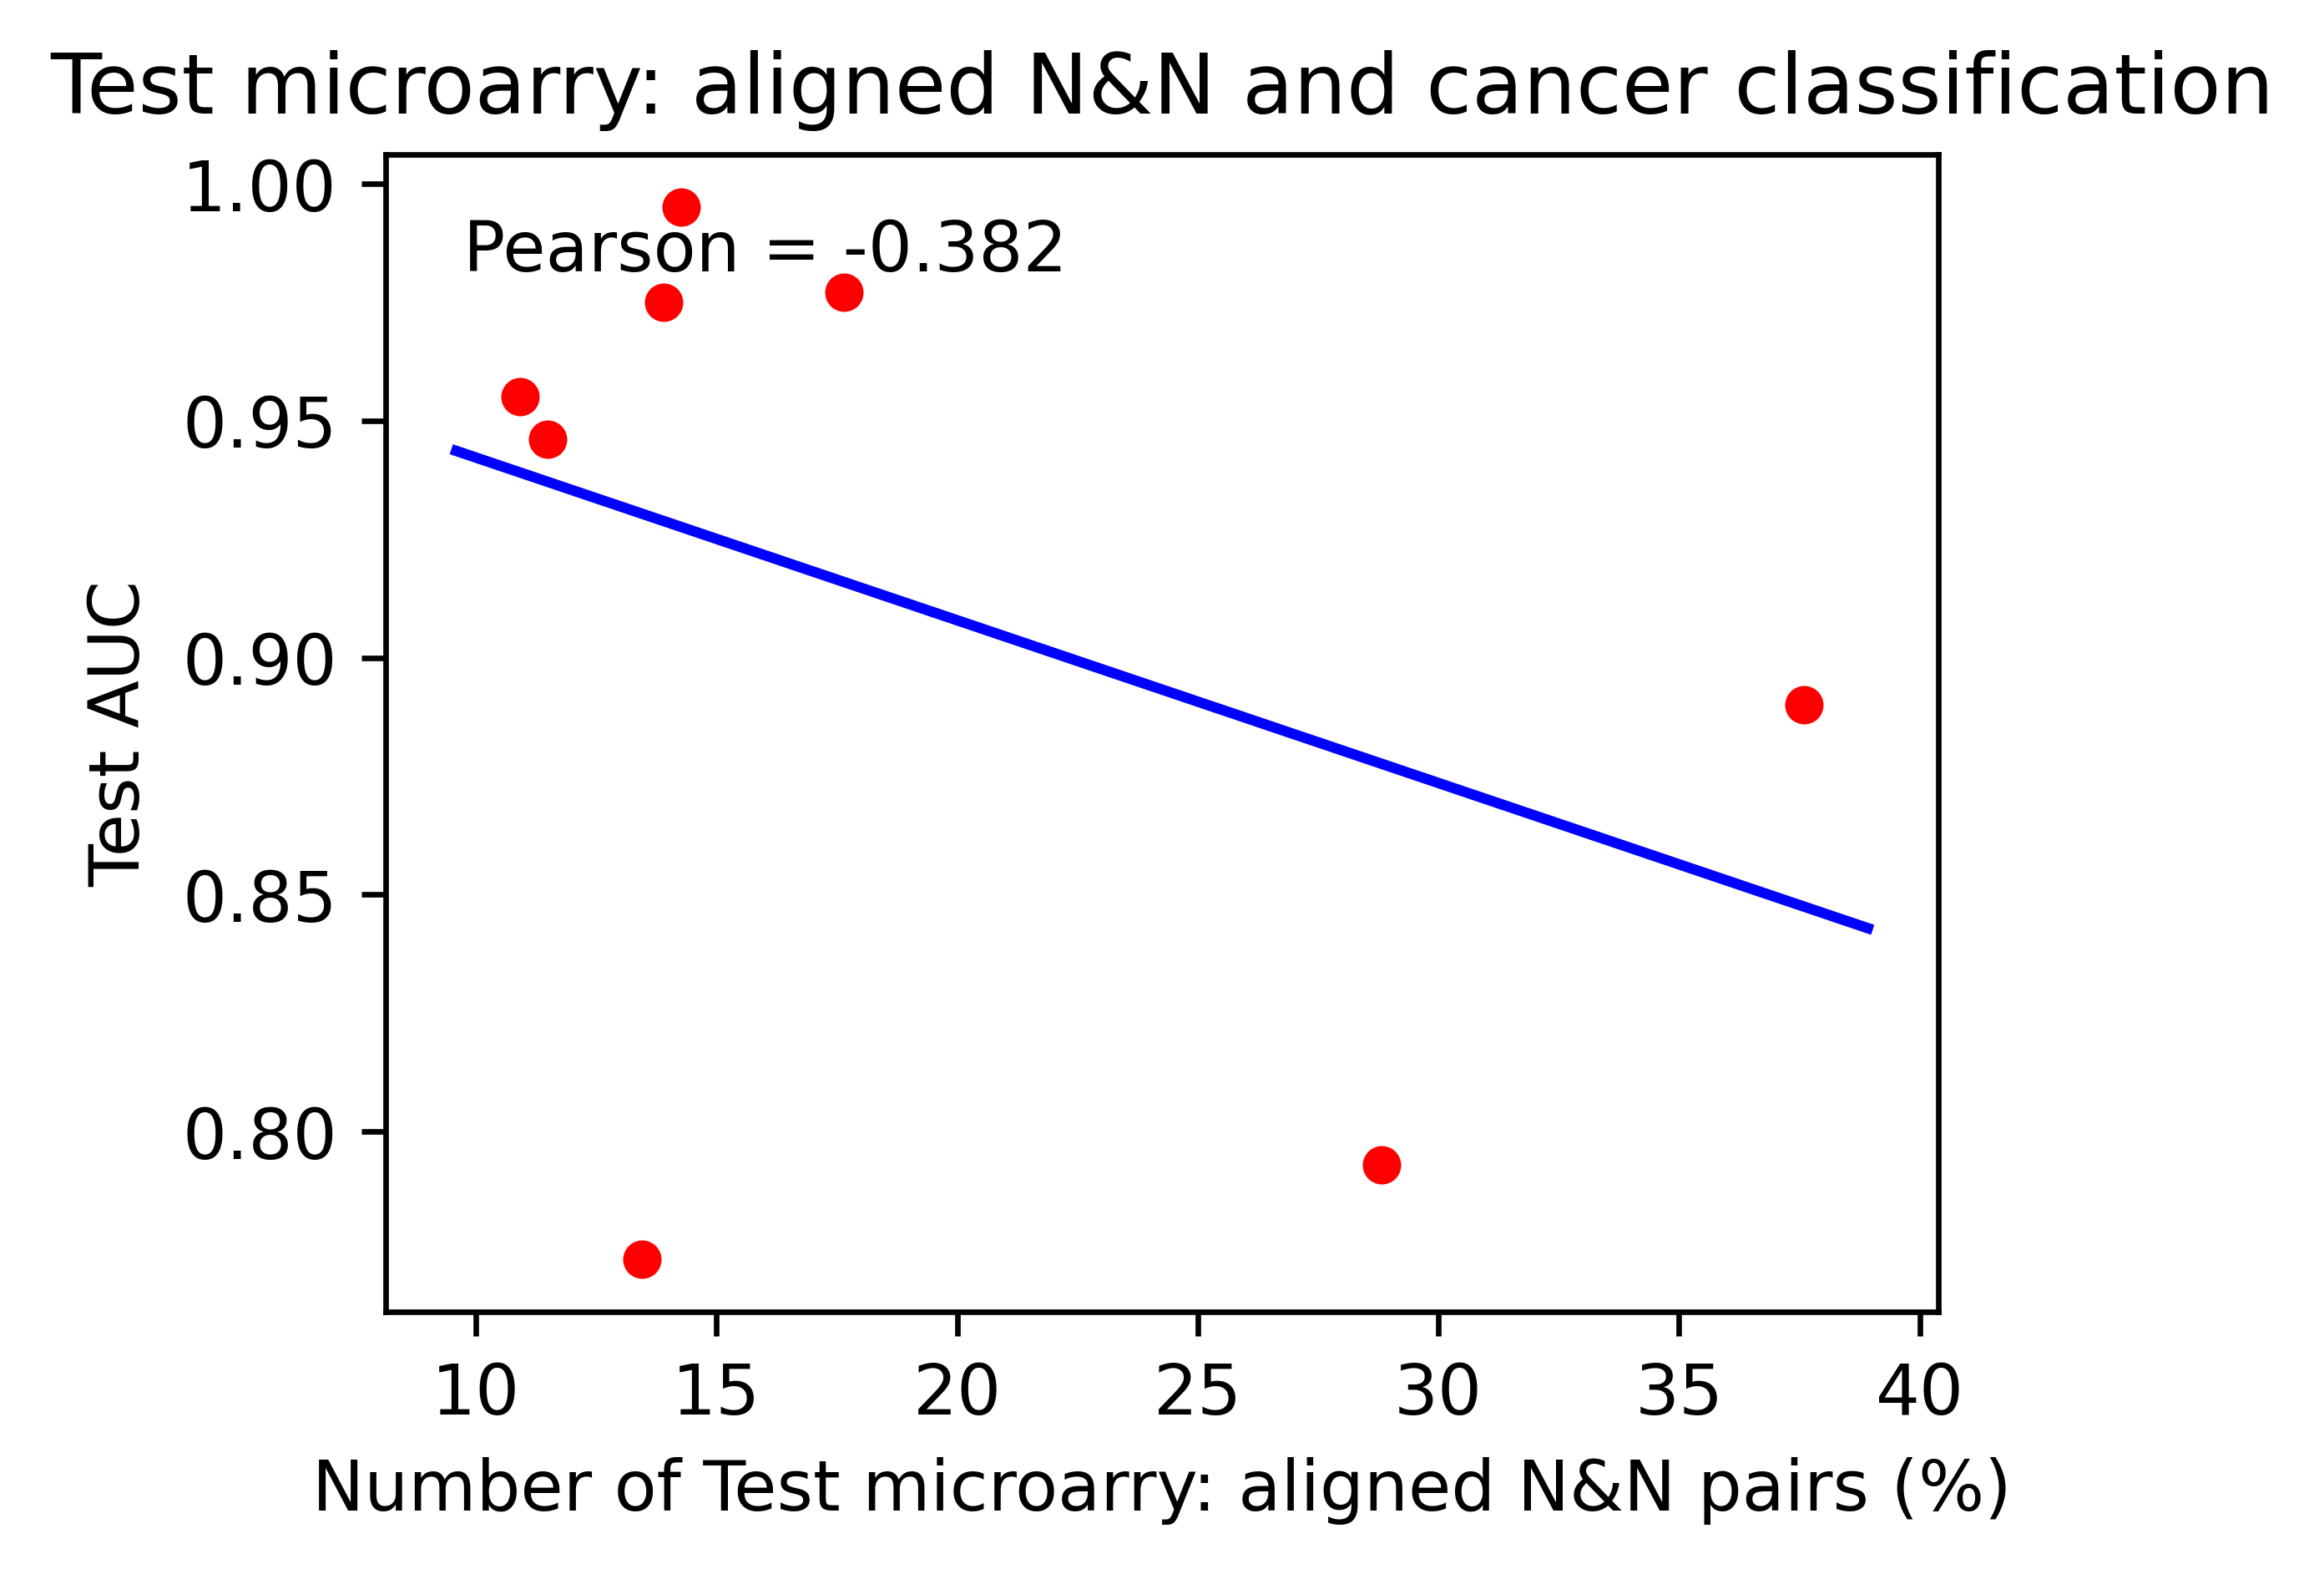

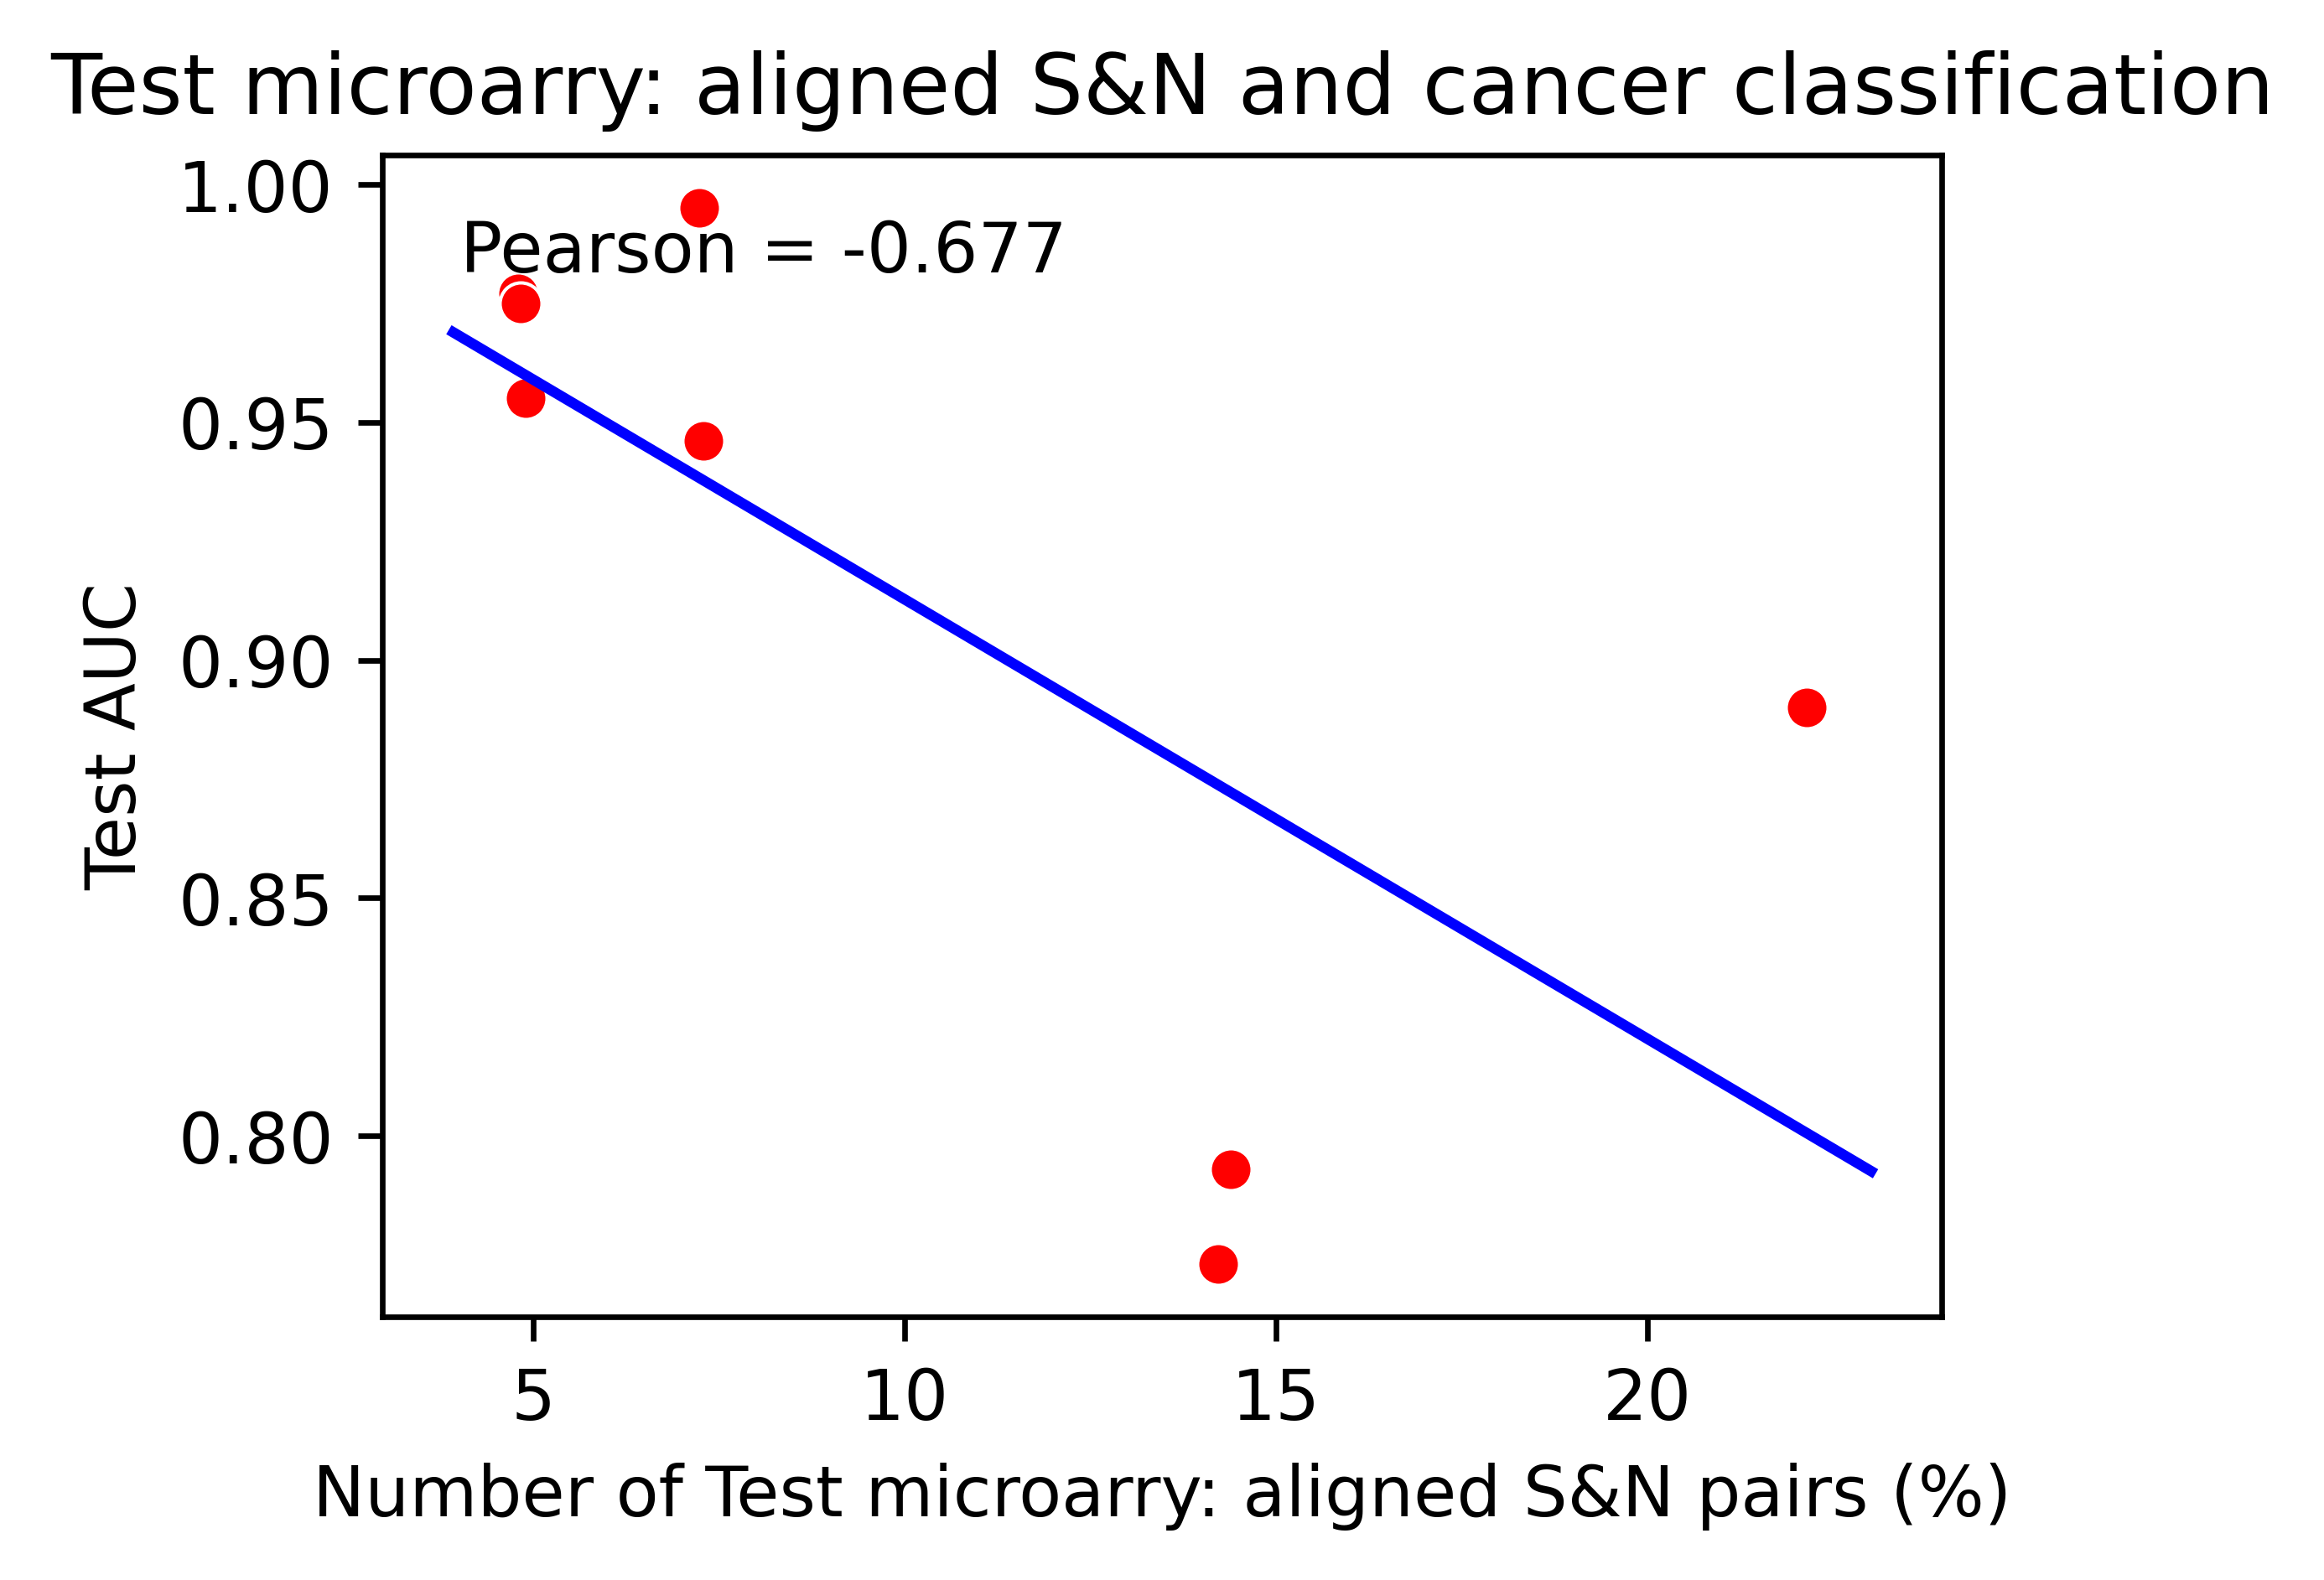

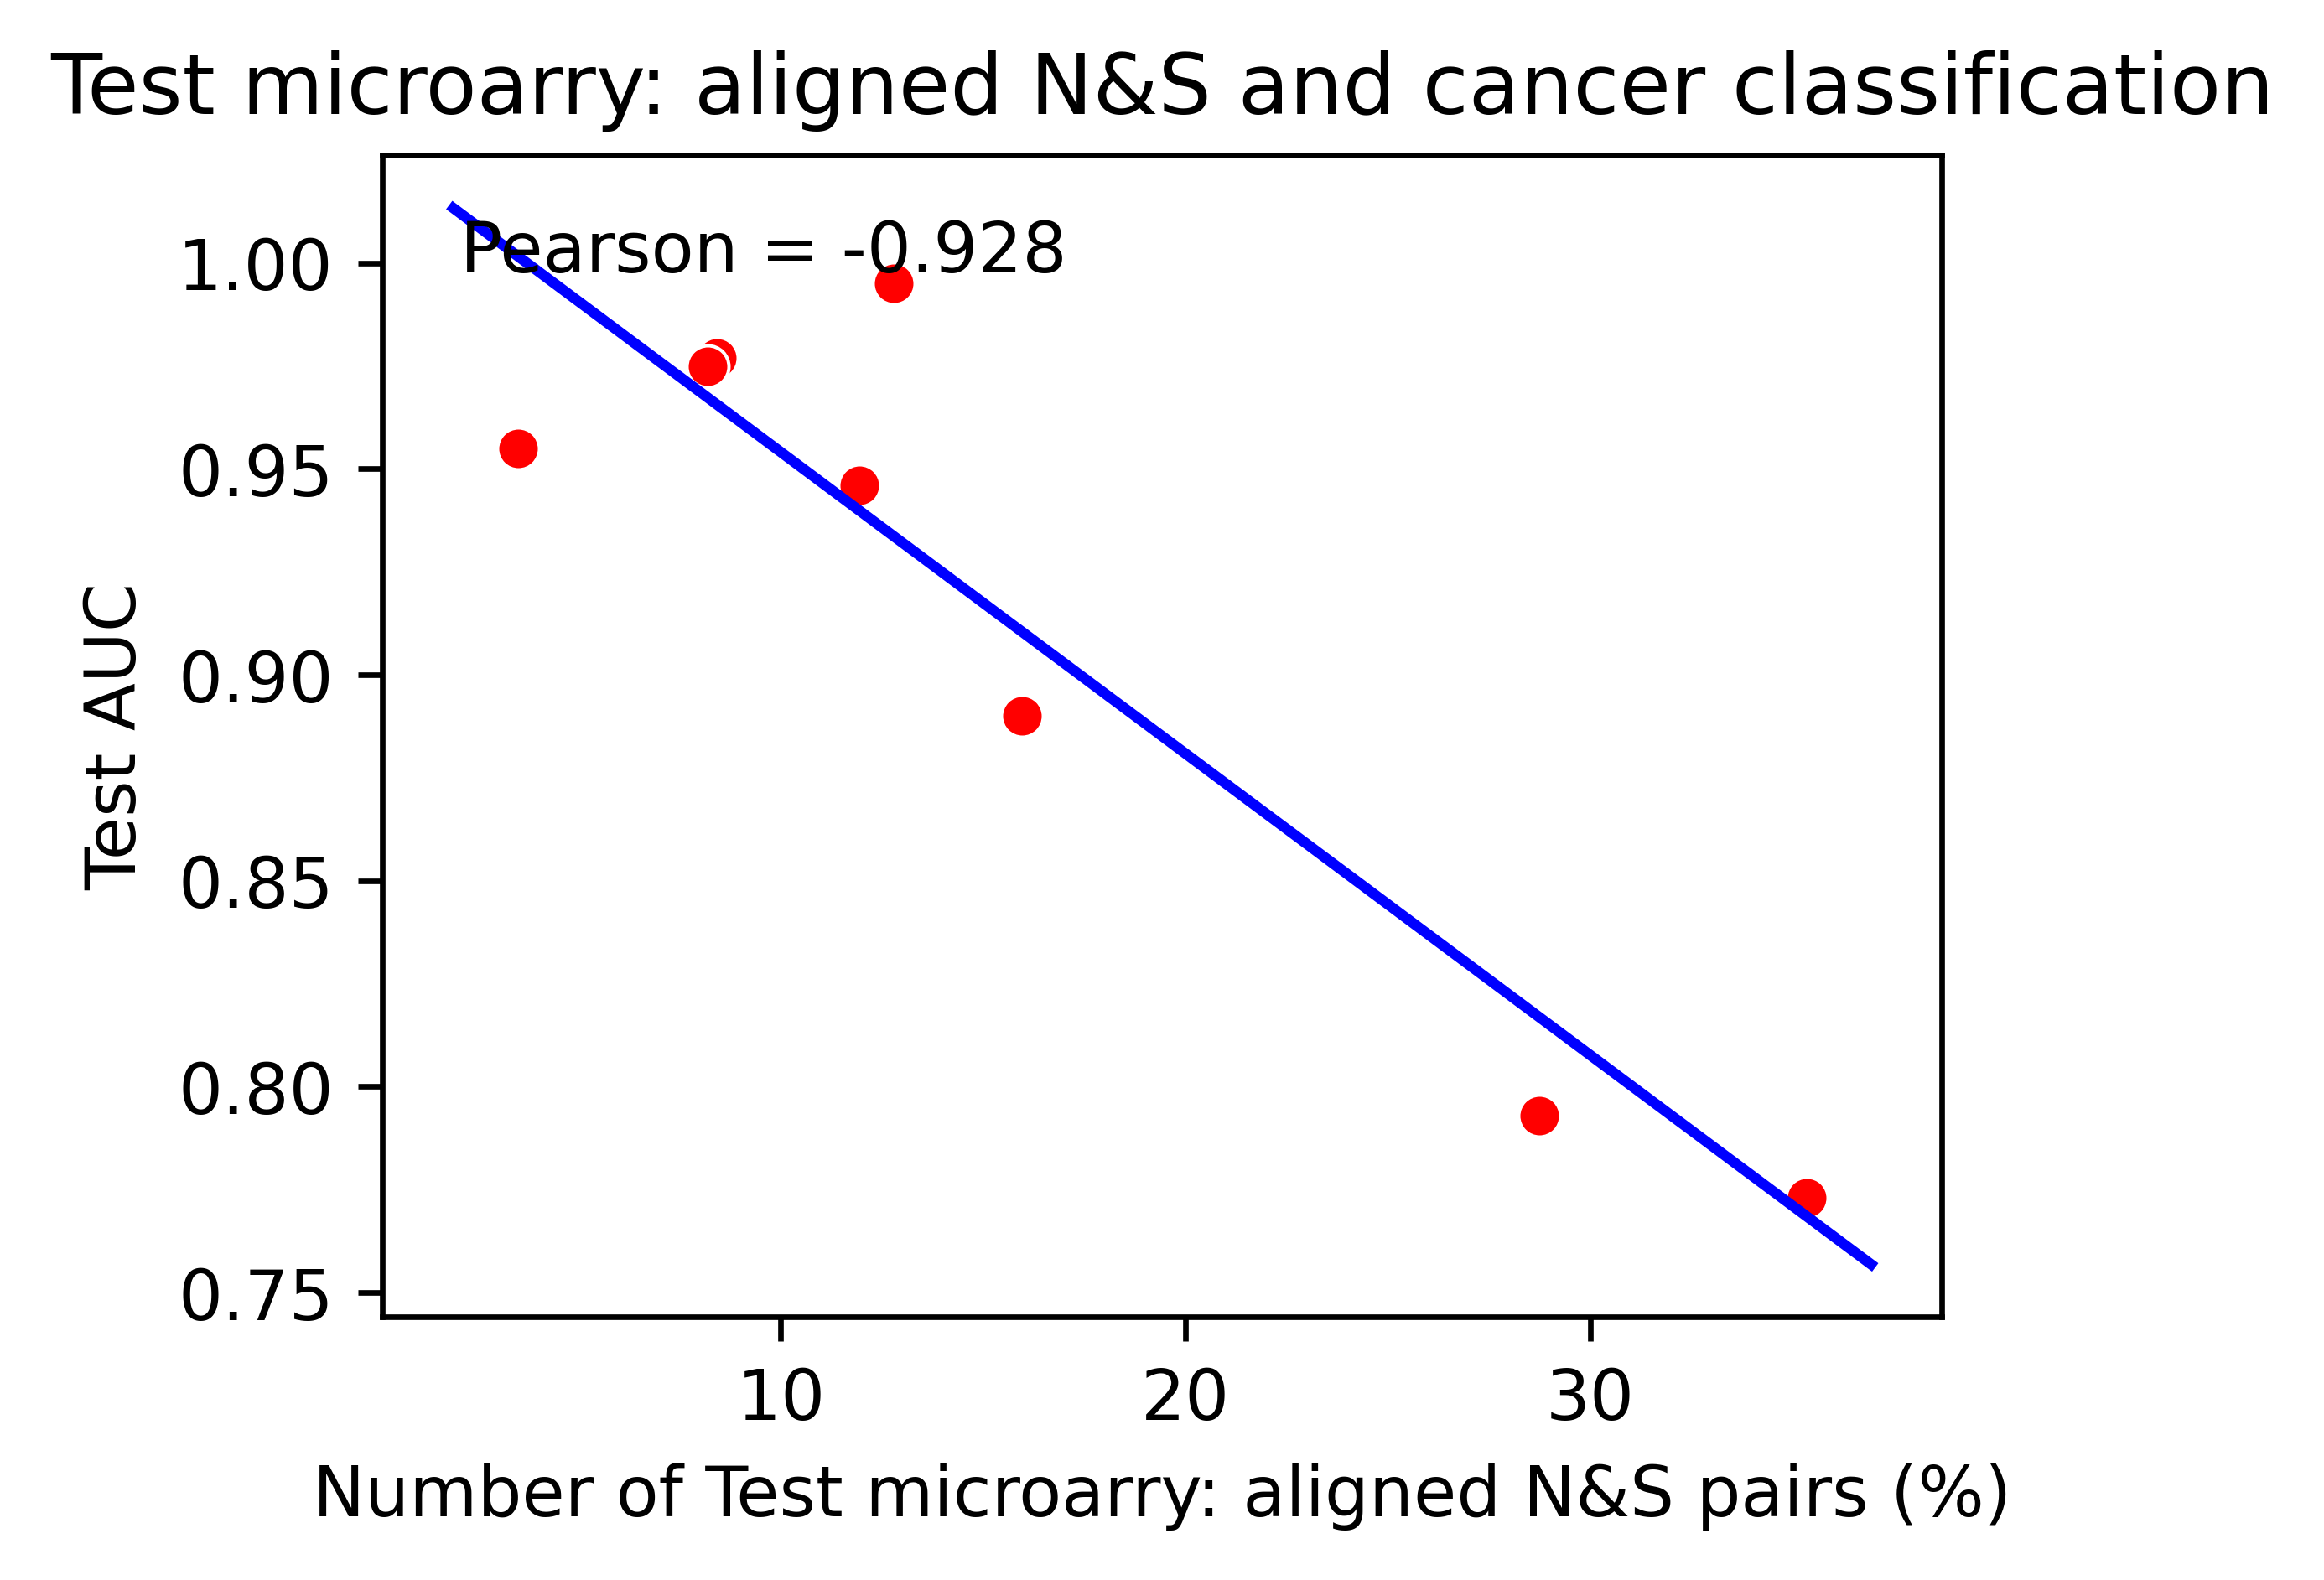

In [6]:
aligned_auc_testarr = {
    "Ovarian Cancer": 0.890, 
    "Breast Cancer": 0.773, 
    "Brain Cancer": 0.977, 
    "Colon/Colorectal Cancer": 0.955, 
    "Lung Cancer": 0.793, 
    "Skin Cancer": 0.995, 
    "Leukemia": 0.975, 
    "Lymphoma": 0.946}

raw_aucs_testarr = {
    "Ovarian Cancer": 0.586, 
    "Breast Cancer": 0.793, 
    "Brain Cancer": 0.947, 
    "Colon/Colorectal Cancer": 0.842, 
    "Lung Cancer": 0.797, 
    "Skin Cancer": 0.966, 
    "Leukemia": 0.956, 
    "Lymphoma": 0.924}
raw_auc_testarr_list = [raw_aucs_testarr[cancer] for cancer in cancers]
aligned_auc_testarr_list = [aligned_auc_testarr[cancer] for cancer in cancers]
plot_correlation(raw_ss_list, raw_auc_testarr_list, "Test microarry: raw S&S")
plot_correlation(raw_nn_list, raw_auc_testarr_list, "Test microarry: raw N&N")
plot_correlation(raw_sn_list, raw_auc_testarr_list, "Test microarry: raw S&N")
plot_correlation(raw_ns_list, raw_auc_testarr_list, "Test microarry: raw N&S")
plot_correlation(aligned_ss_list, aligned_auc_testarr_list, "Test microarry: aligned S&S")
plot_correlation(aligned_nn_list, aligned_auc_testarr_list, "Test microarry: aligned N&N")
plot_correlation(aligned_sn_list, aligned_auc_testarr_list, "Test microarry: aligned S&N")
plot_correlation(aligned_ns_list, aligned_auc_testarr_list, "Test microarry: aligned N&S")

In [ ]:
## build the regression model of test auc and [SS, NN, SN, NS]
from sklearn.linear_model import LinearRegression
def fit_linear(xs, ys):
    model = LinearRegression()
    model.fit(xs, ys)
    coeffs = model.coef_
    return coeffs
raw_info = [[raw_ss_list[i], raw_nn_list[i], raw_sn_list[i], raw_ns_list[i]] for i in range(len(raw_ss_list))]
raw_auc = []

## get train val test ids

In [3]:

train_ids, val_ids, test_ids = get_cancer_train_val_test_stratified(cancer, dis_names_rna, raw_rna_ids)
train_cancers = np.array([get_disease_by_id(bio_df, id_) for id_ in train_ids])
val_cancers = np.array([get_disease_by_id(bio_df, id_) for id_ in val_ids])
test_cancers = np.array([get_disease_by_id(bio_df, id_) for id_ in test_ids])

410 137 137


In [4]:
train_raw, val_raw, test_raw = get_train_val_test_by_ids(
            train_ids, val_ids, test_ids, raw_arr_ids, raw_rna_ids, raw_arr, raw_rna, test_type)
train_aligned, val_aligned, test_aligned = get_train_val_test_by_ids(
            train_ids, val_ids, test_ids, aligned_arr_ids, aligned_rna_ids, aligned_arr, aligned_rna, test_type)

In [ ]:
raw_out = os.path.join(out_dir, "raw_auc_test{}.csv".format(args.test))

res = check_cancer_pred_clf_featImp(
    args.max_eval, bio_df, dis_names_rna,
    data_rna.values.squeeze(),
    data_arr.values.squeeze(),
    ids_rna, ids_arr,
    raw_out,
    test_type = args.test,
    save_prob = True,
    scale = args.zscore
)
